# SpikeInterface Tutorial -  GDR School Lyon - October 2021


In this practice, you will use SpikeInterface to analyze a 64-channel dataset from am "ASSY-156-P1" probe from Cambridge Neurotech. 
The dataset is kindly provided by [Samuel McKenzie's Lab](https://mckenzieneurolab.com/). 

The objective of this practice is for you to familiarize with SpikeInterface on a real-world example and to explore its capabilities and functionalities.

# Table of contents

* [0. Preparation](#preparation)
* [1. Loading the data and probe information](#loading)
* [2. Preprocessing](#preprocessing)
* [3. Saving and loading SpikeInterface objects](#save-load)
* [4. Spike sorting](#spike-sorting)
* [5. Extracting waveforms](#waveforms)
* [6. Postprocessing](#postprocessing)
* [7. Viewers](#viewers)
* [8. Validation and curation](#curation)
* [9. Spike sorting comparison](#comparison)


# 0. Preparation <a class="anchor" id="preparation"></a>

### Download the ephys data

First, we need to download the recording (you should have this already). Feel free to use your own recordings as well later on. 

The dataset is called `cambridge_data.dat` and can be found on this [drive link](https://drive.google.com/drive/folders/1eWPuOd8q4MjpVpwazkWygQJDzJnToN3i) (`practice_2_real_dataset` folder). Move the dataset in the current folder.
The recording was performed with the "ASSY-156-P1" probe with 4 shanks of 16 channels (in total 64 channels).


### Import the modules

Let's now import the `spikeinterface` modules that we need:

In [1]:
import spikeinterface as si
import spikeinterface.extractors as se 
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

In [2]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook

# 1. Loading recording and probe information <a class="anchor" id="loading"></a>

In [3]:
# file path
recording_file = 'cambridge_data.dat'

# parameters to load the bin/dat format
num_channels = 64
sampling_frequency = 20000
gain_to_uV = 0.195
offset_to_uV = 0
dtype = "int16"
time_axis = 0

In [ ]:
si.read_binary?

In [4]:
recording = si.read_binary(recording_file, num_chan=num_channels, sampling_frequency=sampling_frequency,
                           dtype=dtype, gain_to_uV=gain_to_uV, offset_to_uV=offset_to_uV, 
                           time_axis=time_axis)

The `read_binary()` function returns a `RecordingExtractor` object. We can print it to visualize some of its properties:

In [5]:
print(recording)

BinaryRecordingExtractor: 64 channels - 1 segments - 20.0kHz - 600.000s
  file_paths: ['/Users/abuccino/Documents/Codes/teaching/school_spike_sorting_lyon_2021/Practice_2_spikeinterface_pipeline/cambridge_data.dat']


We can further `annotate` the recording to tell SI that it is not filtered yet. This will prevent further mistakes in the pipieline, such as attempting to extract waveforms from unfiltered data.

In [6]:
recording.annotate(is_filtered=False)

While the `read_binary()` function is part of the `core` module (as it's used internally by SI to store data in a convenient format), the `extractor` module allows you to load many file formats used in electrophysiology. 

The extractors available in SI are all loaded using the [NEO](https://neo.readthedocs.io/en/stable/) python package.

A `RecordingExtractor` object extracts information about channel ids, channel locations (if present), the sampling frequency of the recording, and the extracellular traces (when prompted). The `BinaryRecordingExtractor` is designed specifically for raw binary files datasets (.bin, .dat, .raw).

Here we load information from the recording using the built-in functions from the RecordingExtractor

In [7]:
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_segments = recording.get_num_segments()

print(f'Channel ids: {channel_ids}')
print(f'Sampling frequency: {fs}')
print(f'Number of channels: {num_chan}')
print(f"Number of segments: {num_segments}")

Channel ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Sampling frequency: 20000
Number of channels: 64
Number of segments: 1


### Exercise 1a) Explore traces

Explore the `recording.get_traces()` function. What are its arguments? What is the shape of the returned signals? What is the unit? 

Try to plot the traces of some channels using `matplotlib`.

### 1a) SOLUTION

In [14]:
# we have to extract only a chunk of the traces (let's say 5 seconds) otherwise the data would not fit on our RAM

# we can extract traces as raw int16 (default) as:
traces = recording.get_traces(start_frame=10*fs, end_frame=15*fs)

<IPython.core.display.Javascript object>


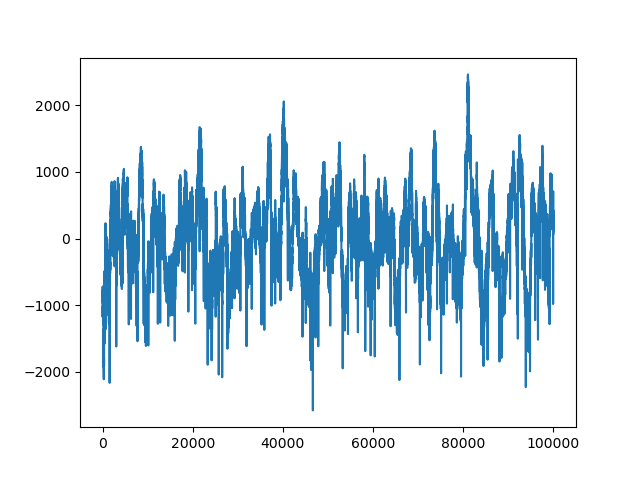

In [10]:
fix, ax = plt.subplots()
ax.plot(traces[:, 4])
ax.set_xlabel("sample number")
ax.set_ylabel("raw ADC output")

In [12]:
# we can extract traces in uV with the return_scaled argument
traces_uV = recording.get_traces(start_frame=10*fs, end_frame=15*fs, return_scaled=True)

<IPython.core.display.Javascript object>


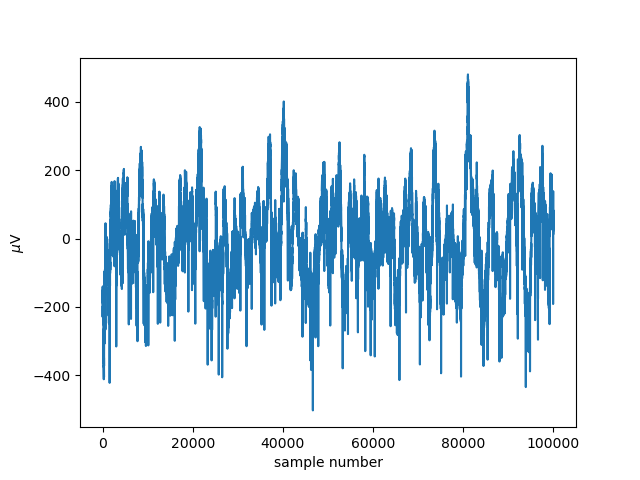

Text(0, 0.5, '$\\mu$V')

In [13]:
fix, ax = plt.subplots()
ax.plot(traces_uV[:, 4])
ax.set_xlabel("sample number")
ax.set_ylabel("$\mu$V")

**IMPORTANT**: The `widgets` module includes several convenient plotting functions that can be used to explore the data:

<IPython.core.display.Javascript object>


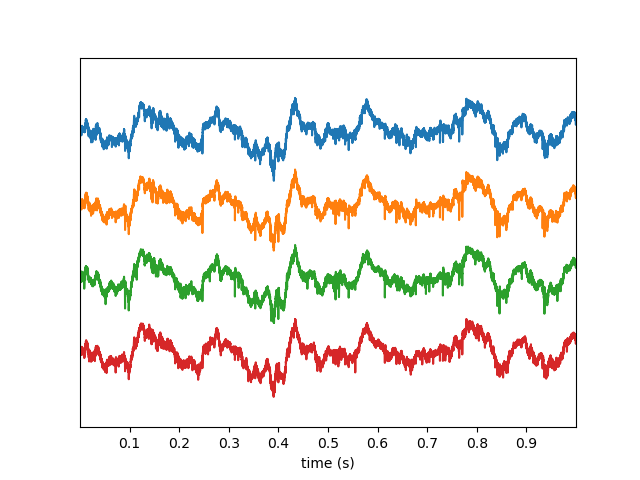

In [26]:
w_ts = sw.plot_timeseries(recording, channel_ids=[0, 1, 2, 3])

Before moving on with the analysis, we have to load the probe information. For this we will use the [ProbeInterface](https://probeinterface.readthedocs.io/en/main/index.html) package. 

ProbeInterface allows to easily create, manipulate, and visualize neural probes. Moreover, it comes with a wide range of IO functions to import and export existing formats. Finally, we have created a public library of commercial probes (https://gin.g-node.org/spikeinterface/probeinterface_library/) that can be retrieved with a single line of code.

Let's import `probeinterface`, download the probe and plot it!

In [27]:
import probeinterface as pi
from probeinterface import plotting

In [28]:
manufacturer = 'cambridgeneurotech'
probe_name = 'ASSY-156-P-1'

probe = pi.get_probe(manufacturer, probe_name)
print(probe)

cambridgeneurotech - ASSY-156-P-1 - 64ch


In most experiments, the neural probe has a connector, that is interfaced to an headstage, which in turn connects to the acquisition system. This *pathway* usually results in a channel remapping, which means that the order of the contacts on the probe is different than the order of the recorded traces.

`probeinterface` provides a growing collection of common pathways that can be loaded directly to wire a device and apply the correct channel mapping:

In [29]:
pi.get_available_pathways()

['H32>RHD2132', 'ASSY-156>RHD2164', 'ASSY-77>Adpt.A64-Om32_2x-sm>RHD2164']

In [30]:
probe.wiring_to_device('ASSY-156>RHD2164')

<IPython.core.display.Javascript object>


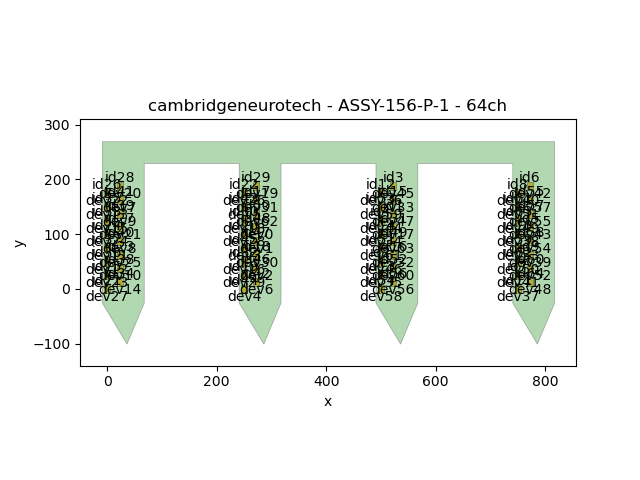

(<matplotlib.collections.PolyCollection at 0x7ffcf7013d00>,
 <matplotlib.collections.PolyCollection at 0x7ffcf73583a0>)

In [31]:
plotting.plot_probe(probe, with_contact_id=True, with_device_index=True)

The probe now has contact ids `id#` and device ids `dev#`! We can also visualize the probe information as a `pandas` dataframe:

In [32]:
probe.to_dataframe(complete=True).loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]]

contact_ids shank_ids  device_channel_indices
0            1         2                      47
1            2         2                      46
2            3         2                      45
3            4         2                      44
4            5         3                      43
..         ...       ...                     ...
59          60         3                      52
60          61         3                      51
61          62         3                      50
62          63         3                      49
63          64         3                      48

[64 rows x 3 columns]

Note that also the `shank_id` is loaded with the probe.

In [33]:
recording_prb = recording.set_probe(probe, group_mode="by_shank")

When loading the probe, the device indices (and all the other contact properties) are automatically sorted:

In [34]:
probe_rec = recording_prb.get_probe()
probe_rec.to_dataframe(complete=True).loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]]

contact_ids shank_ids  device_channel_indices
0           48         1                       0
1           47         1                       1
2           46         1                       2
3           45         1                       3
4           44         1                       4
..         ...       ...                     ...
59          53         2                      59
60          52         2                      60
61          51         2                      61
62          50         1                      62
63          49         2                      63

[64 rows x 3 columns]

In [35]:
print(f'Channels after loading the probe file: {recording_prb.get_channel_ids()}')
print(f'Channel groups after loading the probe file: {recording_prb.get_channel_groups()}')

Channels after loading the probe file: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Channel groups after loading the probe file: [1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 2 1 1 0 0 0 0 0 0 1 0 1 1 1 1 2 2 2 2 2
 3 3 3 3 3 3 3 2 2 2 2 3 3 3 3 3 3 3 3 2 3 2 2 2 2 1 2]


### Properties 

`RecordingExtractor` object can have *properties*. A property is a piece of information attached to a channel, e.g. group or location.

Similarly, for `SortingExtractor` objects (that we'll cover later), anything related to a unit can be stored as a property. 

We can check which properties are in the extractor as follows:

In [36]:
print("Properties before loading the probe:", list(recording.get_property_keys()))

Properties before loading the probe: ['gain_to_uV', 'offset_to_uV', 'impedance', 'brain_area']


In [37]:
print("Properties after loading the probe:", list(recording_prb.get_property_keys()))

Properties after loading the probe: ['gain_to_uV', 'offset_to_uV', 'impedance', 'brain_area', 'contact_vector', 'location', 'group']


After loading the probe we now have some new properties: `contact_vector`, `location`, and `group`.

Let's add some new properties! 
The first 32 channels are in the CA1 area, the second 32 are in the CA3 area:

### Exercise 1b) Add a custom property

We can use the `recording.set_property()` function to add custom properties to a SpikeInterface object. Properties are useful to store pieces of information across the analysis. 

Try to add a custom property to your `recording_prb` object (e.g. brain area, impedance, etc.). Check that the property was correctly added once you're done.

In [38]:
recording_prb.set_property?

In [ ]:
# Add your property(ies) here

### 1b) SOLUTION

Let's add a custom property called 'impedance'. We assume this is the impedance of the electrode, it has a mean of 200kohm and a standard deviation of 20kohm.

<IPython.core.display.Javascript object>


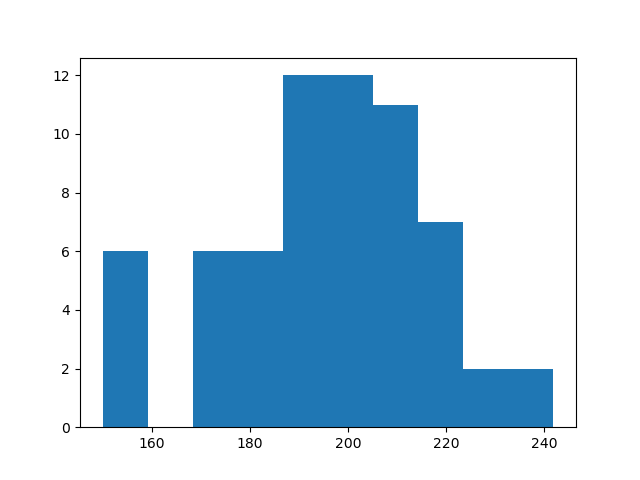

In [39]:
impedances = 200 + 20 * np.random.randn(recording.get_num_channels())

plt.figure()
_ = plt.hist(impedances)

In [41]:
recording_prb.set_property(key="impedance", values=impedances)

### (Optional) 1c) Can you add a property to a subset of channels? 

### 1c) SOLUTION

Let's find out. We can add a new property "brain_area" on a subset of channels:

In [42]:
channel_subset_ids = recording.get_channel_ids()[:10]
brain_areas = ["hippocampus"] * len(channel_subset_ids)

print("channel subset", channel_subset_ids)
print("brain_areas", brain_areas)

channel subset [0 1 2 3 4 5 6 7 8 9]
brain_areas ['hippocampus', 'hippocampus', 'hippocampus', 'hippocampus', 'hippocampus', 'hippocampus', 'hippocampus', 'hippocampus', 'hippocampus', 'hippocampus']


In [43]:
recording_prb.set_property(key="brain_area", values=brain_areas, ids=channel_subset_ids)

In [44]:
recording_prb.get_property("brain_area")

array(['hippocampus', 'hippocampus', 'hippocampus', 'hippocampus',
       'hippocampus', 'hippocampus', 'hippocampus', 'hippocampus',
       'hippocampus', 'hippocampus', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', ''], dtype='<U11')

Missing properties are filled in with empty strings! (In case of string properties...)

In [45]:
print("Properties after adding custom properties:", list(recording_prb.get_property_keys()))

Properties after adding custom properties: ['gain_to_uV', 'offset_to_uV', 'impedance', 'brain_area', 'contact_vector', 'location', 'group']


# 2. Preprocessing <a class="anchor" id="preprocessing"></a>


Now that the probe information is loaded we can do some preprocessing using `toolkit` module.

We can filter the recordings, rereference the signals to remove noise, discard noisy channels, whiten the data, remove stimulation artifacts, etc. (more info [here](https://spiketoolkit.readthedocs.io/en/latest/preprocessing_example.html)).

For this notebook, let's filter the recordings and apply common median reference (CMR). All preprocessing modules return new `RecordingExtractor` objects that apply the underlying preprocessing function. This allows users to access the preprocessed data in the same way as the raw data.

We will focus only on the first shank (grouo `0`) for the following analysis:

In [46]:
recordings_by_group = recording_prb.split_by("group")
print(recordings_by_group)

{0: ChannelSliceRecording: 16 channels - 1 segments - 20.0kHz - 600.000s, 1: ChannelSliceRecording: 16 channels - 1 segments - 20.0kHz - 600.000s, 2: ChannelSliceRecording: 16 channels - 1 segments - 20.0kHz - 600.000s, 3: ChannelSliceRecording: 16 channels - 1 segments - 20.0kHz - 600.000s}


In [47]:
group_to_sort = 2

In [48]:
recording_to_process = recordings_by_group[2]

Below, we bandpass filter the recording:

<IPython.core.display.Javascript object>


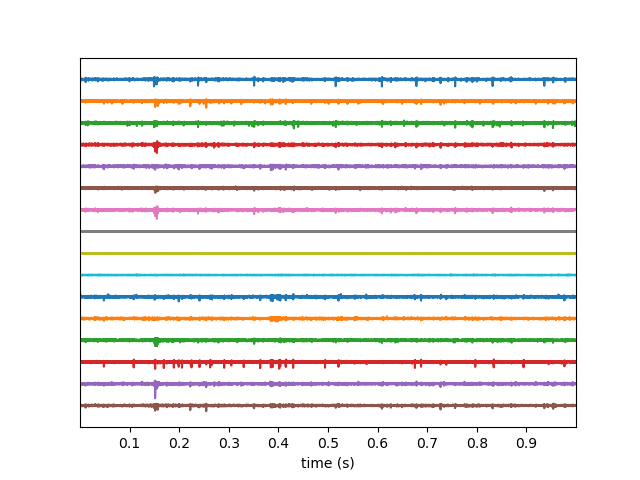

In [49]:
recording_f = st.bandpass_filter(recording_to_process, freq_min=300, freq_max=6000)

w = sw.plot_timeseries(recording_f)

We can see that the after filtering we can observe spiking activity on many channels! We can also apply other preprocessing steps to further increase the quality of the recording. 

### Exercise 2a) Explore noise reduction methods

We can use the `toolkit` module to further increase the quality of the traces before spike sorting.
Several available preprocessors are available for this purpose.

- Explore the `toolkit.preprocessing` module (`st.preprocessing`) to find functions that could remove noise (e.g. by re-referencing the signal).

- Choose a preprocessing step and apply it to the filtered recording (`recording_f`)

- Compare the traces to the filtered traces

### 2a) SOLUTION 


We are going to use toe `common_reference` function. Depending on the nature of noise, other preprocessing steps may be appropriate:

* `remove_bad_channels`: some channels have very high noise compared to others
* `notch_filter`: 50-60Hz line interference or localized noise sources
* `remove_artifacts`: blank out or interpolate artifacts due to, for example, electrical stimulation

In [52]:
#st.preprocessing

In [54]:
recording_cmr_global = st.common_reference(recording_f, reference="global", operator="median")

In [55]:
recording_cmr_local = st.common_reference(recording_f, reference="local", operator="median")

<IPython.core.display.Javascript object>


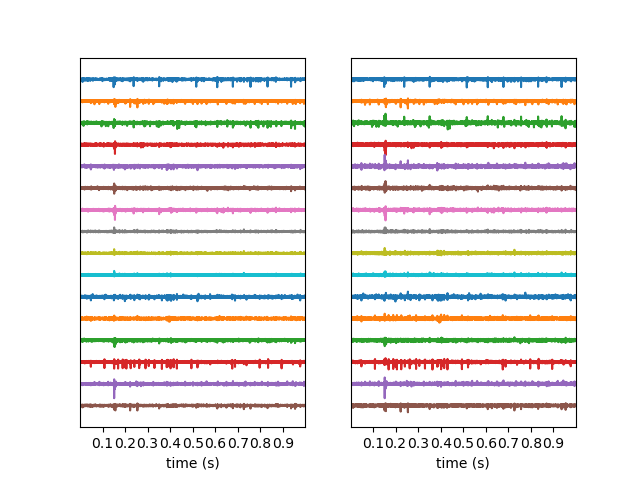

In [57]:
fig, axs = plt.subplots(ncols=2)
_ = sw.plot_timeseries(recording_cmr_global, ax=axs[0])
_ = sw.plot_timeseries(recording_cmr_local, ax=axs[1])

In [70]:
# Use the right object to continue with the analysis
recording_processed = recording_cmr_global 

### Exercise 2b) Visual exploration preprocessing methods with `ephyviewer`

In [58]:
import ephyviewer

In [64]:
app = ephyviewer.mkQApp()
win = ephyviewer.MainViewer(debug=False, show_auto_scale=True)

In [65]:
sig_source = ephyviewer.SpikeInterfaceRecordingSource(recording=recording_to_process)
sig_filtered_source = ephyviewer.SpikeInterfaceRecordingSource(recording=recording_f)

In [66]:
view1 = ephyviewer.TraceViewer(source=sig_source, name='signals')
view1.params['scale_mode'] = 'same_for_all'
win.add_view(view1)

view2 = ephyviewer.TraceViewer(source=sig_filtered_source, name='signals filtered')
view2.params['scale_mode'] = 'same_for_all'
win.add_view(view2)

In [67]:
# you can add more views here!

sig_cmr_source = ephyviewer.SpikeInterfaceRecordingSource(recording=recording_cmr_global)

view3 = ephyviewer.TraceViewer(source=sig_cmr_source, name='signals cmr')
view3.params['scale_mode'] = 'same_for_all'
win.add_view(view3)

In [68]:
win.show()
app.exec_()

0

![alt text](ephyviewer.png "Ephyviewer")


Since we are going to spike sort the data, let's first cut out a 5-minute recording, to speed up computations.

We can easily do so with the `frame_slice()` function:

In [71]:
fs = recording_processed.get_sampling_frequency()
recording_sub = recording_processed.frame_slice(start_frame=0*fs, end_frame=300*fs)

# 3. Saving and loading SpikeInterface objects <a class="anchor" id="save-load"></a>

All operations in SpikeInterface are *lazy*, meaning that they are not performed if not needed. This is why the creation of our filter recording was almost instantaneous. However, to speed up further processing, we might want to **save** it to a file and perform those operations (eg. filters, CMR, etc.) at once. 

In [72]:
recording_saved = recording_sub.save(folder="preprocessed", progress_bar=True, 
                                     n_jobs=4, total_memory="100M")

write_binary_recording with n_jobs 4  chunk_size 781250


write_binary_recording: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.15it/s]


The `save` returns a new *cached* recording that has all the previously loaded information:

In [73]:
print(f'Cached channels ids: {recording_saved.get_channel_ids()}')
print(f'Channel groups after caching: {recording_saved.get_channel_groups()}')

Cached channels ids: [17 32 33 34 35 36 44 45 46 47 56 58 59 60 61 63]
Channel groups after caching: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


After saving the SI object, we can easily load it back in a new session:

In [74]:
recording_loaded = si.load_extractor("preprocessed/")

In [75]:
print(f'Loaded channels ids: {recording_loaded.get_channel_ids()}')
print(f'Channel groups after loading: {recording_loaded.get_channel_groups()}')

Loaded channels ids: [17 32 33 34 35 36 44 45 46 47 56 58 59 60 61 63]
Channel groups after loading: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


We can double check that the traces are exactly the same as the `recording_saved` that we saved:

<IPython.core.display.Javascript object>


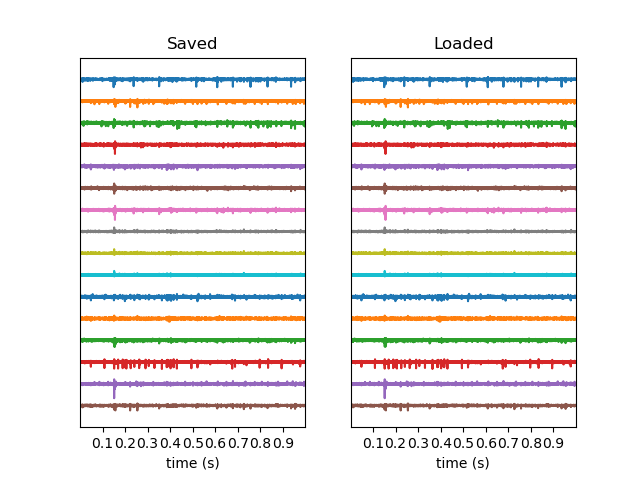

Text(0.5, 1.0, 'Loaded')

In [76]:
fig, axs = plt.subplots(ncols=2)
w_saved = sw.plot_timeseries(recording_saved, ax=axs[0])
w_loaded = sw.plot_timeseries(recording_loaded, ax=axs[1])
axs[0].set_title("Saved")
axs[1].set_title("Loaded")

**IMPORTANT**: the same saving mechanisms are available also for all SortingExtractor

# 4. Spike sorting <a class="anchor" id="spike-sorting"></a>

We can now run spike sorting on the above recording.

Let's first check the installed sorters in SpikeInterface.
We will sort the bandpass cached filtered recording the `recording_saved` object.

In [77]:
ss.installed_sorters()

/Users/abuccino/anaconda3/envs/school_lyon/lib/python3.8/site-packages/spikemetrics-0.2.4-py3.8.egg/spikemetrics/metrics.py:791: DeprecationWarning: invalid escape sequence \s
/Users/abuccino/anaconda3/envs/school_lyon/lib/python3.8/site-packages/spikemetrics-0.2.4-py3.8.egg/spikemetrics/metrics.py:791: DeprecationWarning: invalid escape sequence \s


['herdingspikes', 'mountainsort4', 'spykingcircus', 'tridesclous']

We can retrieve the parameters associated to any sorter with the `get_default_params()` function from the `sorters` module:

In [78]:
sorter_name = 'tridesclous'

In [79]:
ss.get_default_params(sorter_name)

{'freq_min': 400.0,
 'freq_max': 5000.0,
 'detect_sign': -1,
 'detect_threshold': 5,
 'common_ref_removal': False,
 'nested_params': None,
 'total_memory': '500M',
 'n_jobs_bin': 1}

In [80]:
ss.get_params_description(sorter_name)

{'freq_min': 'High-pass filter cutoff frequency',
 'freq_max': 'Low-pass filter cutoff frequency',
 'detect_threshold': 'Threshold for spike detection',
 'detect_sign': 'Use -1 (negative) or 1 (positive) depending on the sign of the spikes in the recording',
 'common_ref_removal': 'remove common reference with median',
 'total_memory': 'Chunk size in Mb for saving to binary format (default 500Mb)',
 'n_jobs_bin': 'Number of jobs for saving to binary format (Default 1)'}

### Exercise 4a) Spike sort your data

The `ss.run_sorter()` function from the `sorters` module is where the spike sorting happens! The function returns a `SortingExtractor` object, which allows you to retrieve spiking data (e.g. unit ids, spike trains, etc.)

Run a spike sorter installed on your system and explore the returned `SortingExtractor` object.

In [ ]:
ss.run_sorter?

To modify a parameter, we can easily pass it to the `run` function as an extra argument!
For example, let's set the `filter` parameter to False as the recording is already preprocessed:

### 4a) SOLUTION

In [101]:
# run spike sorting on entire recording
sorting = ss.run_sorter(sorter_name=sorter_name, recording=recording_saved,
                        output_folder="output_TDC", verbose=True)

DataIO <id: 140719046417136> 
  workdir: output_TDC
  sample_rate: 20000.0
  total_channel: 16
  channel_groups: 0 [ch0 ch1 ch2 ch3 ... ch12 ch13 ch14 ch15]
  nb_segment: 1
  length: 6000000
  durations: 300.0 s.
catalogue_nested_params
{'chunksize': 20000,
 'clean_cluster': {'apply_auto_merge_cluster': True,
                   'apply_auto_split': True,
                   'apply_trash_low_extremum': True,
                   'apply_trash_not_aligned': True,
                   'apply_trash_small_cluster': True},
 'clean_peaks': {'alien_value_threshold': -1.0, 'mode': 'extremum_amplitude'},
 'cluster_kargs': {'adjacency_radius_um': 50.0,
                   'high_adjacency_radius_um': 30.0,
                   'max_loop': 1000,
                   'min_cluster_size': 20},
 'cluster_method': 'pruningshears',
 'duration': 300.0,
 'extract_waveforms': {'wf_left_long_ms': -2.5,
                       'wf_left_ms': -1.0,
                       'wf_right_long_ms': 3.5,
                       'wf_r

/Users/abuccino/anaconda3/envs/school_lyon/lib/python3.8/site-packages/hdbscan/hdbscan_.py:275: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  alg = KDTreeBoruvkaAlgorithm(tree, min_samples, metric=metric,
/Users/abuccino/anaconda3/envs/school_lyon/lib/python3.8/site-packages/hdbscan/hdbscan_.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depre

/Users/abuccino/anaconda3/envs/school_lyon/lib/python3.8/site-packages/hdbscan/hdbscan_.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  condensed_tree = condense_tree(single_linkage_tree,
/Users/abuccino/anaconda3/envs/school_lyon/lib/python3.8/site-packages/hdbscan/hdbscan_.py:59: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in Num

/Users/abuccino/anaconda3/envs/school_lyon/lib/python3.8/site-packages/hdbscan/hdbscan_.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  condensed_tree = condense_tree(single_linkage_tree,
/Users/abuccino/anaconda3/envs/school_lyon/lib/python3.8/site-packages/hdbscan/hdbscan_.py:59: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in Num

/Users/abuccino/anaconda3/envs/school_lyon/lib/python3.8/site-packages/hdbscan/hdbscan_.py:275: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  alg = KDTreeBoruvkaAlgorithm(tree, min_samples, metric=metric,
/Users/abuccino/anaconda3/envs/school_lyon/lib/python3.8/site-packages/hdbscan/hdbscan_.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depre

/Users/abuccino/anaconda3/envs/school_lyon/lib/python3.8/site-packages/hdbscan/hdbscan_.py:275: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  alg = KDTreeBoruvkaAlgorithm(tree, min_samples, metric=metric,
/Users/abuccino/anaconda3/envs/school_lyon/lib/python3.8/site-packages/hdbscan/hdbscan_.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depre

find_clusters 2.323532630000045
cache_some_waveforms 0.1088531650002551
compute_all_centroid 0.44937494600026184
auto_split_cluster 10.923628301000008
trash_not_aligned 0.08257933699997011
auto_merge_cluster 0.39092727600018407
trash_low_extremum 0.09149622699987958
trash_small_cluster 0.09422240799995052
make_catalogue_for_peeler 0.8438190369997756
CatalogueConstructor
  chan_grp 0 - ch0 ch1 ch2 ... ch14 ch15
  nb_peak_by_segment: 62457
  some_features.shape: (15605, 48)
  cluster_labels 18 [-11 -1 0 ... 16 17]

peeler.tun 17.896500793000087
tridesclous run time 40.38s


In [102]:
print(sorting)

print("Unit ids:", sorting.get_unit_ids())

TridesclousSortingExtractor: 18 units - 1 segments - 20.0kHz
Unit ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [103]:
print("Spike train of unit 0:", sorting.get_unit_spike_train(0))

Spike train of unit 0: [  36298   67678   97103  181291  199488  243544  431637  610183  617536
  623508  887884 1514259 1580854 2359616 2561271 2596064 2603380 2605046
 2610208 2614062 2615163 2629186 2951664 2984573 2988558 3038616 3040279
 3110917 3116966 3151752 3155561 3161254 3174531 3177270 3333801 3377919
 3381872 3449469 3453161 3456139 3457452 3463009 3464339 3471170 3472760
 3493476 3494349 3495022 3518676 3520849 3521880 3527513 3538239 3575242
 3594972 3598785 3605163 3608526 3616567 3627536 3636749 3785255 3883533
 3898677 3988635 3990458 3992134 3993459 3994239 3994879 3996527 3996652
 3996874 3999510 4000387 4001060 4005693 4007744 4008993 4011466 4024733
 4052827 4053947 4054278 4054687 4055970 4057564 4057960 4058668 4058970
 4059555 4060094 4060774 4061324 4062703 4063530 4064866 4066425 4067703
 4068433 4069194 4072848 4076026 4077290 4094469 4097425 4099204 4107403
 4117511 4164897 4168124 4171387 4205435 4224321 4228907 4230581 4268412
 4274197 4277945 4280439 428

### Exercise 4b) Change a spike sorter parameter

Parameters (listed above) can be directly passed as extra arguments to the `ss.run_sorter()` function.

Try to choose a parameter, change its default value, and run spike sorting again


### 4b) SOLUTION

Let's try to increase the detection threshold!

In [105]:
# run spike sorting on entire recording
sorting1 = ss.run_sorter(sorter_name=sorter_name, recording=recording_saved,
                         output_folder="output_TDC_thr3", detect_threshold=3, verbose=True)

DataIO <id: 140719045093120> 
  workdir: output_TDC_thr3
  sample_rate: 20000.0
  total_channel: 16
  channel_groups: 0 [ch0 ch1 ch2 ch3 ... ch12 ch13 ch14 ch15]
  nb_segment: 1
  length: 6000000
  durations: 300.0 s.
catalogue_nested_params
{'chunksize': 20000,
 'clean_cluster': {'apply_auto_merge_cluster': True,
                   'apply_auto_split': True,
                   'apply_trash_low_extremum': True,
                   'apply_trash_not_aligned': True,
                   'apply_trash_small_cluster': True},
 'clean_peaks': {'alien_value_threshold': -1.0, 'mode': 'extremum_amplitude'},
 'cluster_kargs': {'adjacency_radius_um': 50.0,
                   'high_adjacency_radius_um': 30.0,
                   'max_loop': 1000,
                   'min_cluster_size': 20},
 'cluster_method': 'pruningshears',
 'duration': 300.0,
 'extract_waveforms': {'wf_left_long_ms': -2.5,
                       'wf_left_ms': -1.0,
                       'wf_right_long_ms': 3.5,
                       

/Users/abuccino/anaconda3/envs/school_lyon/lib/python3.8/site-packages/hdbscan/hdbscan_.py:275: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  alg = KDTreeBoruvkaAlgorithm(tree, min_samples, metric=metric,
/Users/abuccino/anaconda3/envs/school_lyon/lib/python3.8/site-packages/hdbscan/hdbscan_.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depre

/Users/abuccino/anaconda3/envs/school_lyon/lib/python3.8/site-packages/hdbscan/hdbscan_.py:275: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  alg = KDTreeBoruvkaAlgorithm(tree, min_samples, metric=metric,
/Users/abuccino/anaconda3/envs/school_lyon/lib/python3.8/site-packages/hdbscan/hdbscan_.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depre

/Users/abuccino/anaconda3/envs/school_lyon/lib/python3.8/site-packages/hdbscan/hdbscan_.py:275: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  alg = KDTreeBoruvkaAlgorithm(tree, min_samples, metric=metric,
/Users/abuccino/anaconda3/envs/school_lyon/lib/python3.8/site-packages/hdbscan/hdbscan_.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depre

/Users/abuccino/anaconda3/envs/school_lyon/lib/python3.8/site-packages/hdbscan/hdbscan_.py:59: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels, probabilities, stabilities = get_clusters(condensed_tree,
/Users/abuccino/anaconda3/envs/school_lyon/lib/python3.8/site-packages/hdbscan/hdbscan_.py:275: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a

find_clusters 2.9533179550003297
cache_some_waveforms 0.07100572799981819
compute_all_centroid 0.26873502299986285
auto_split_cluster 0.7764631730001383
trash_not_aligned 0.0930700550002257
auto_merge_cluster 0.1319994300001781
trash_low_extremum 0.0939967220001563
trash_small_cluster 0.09269626600007541
make_catalogue_for_peeler 0.26972913299960055
CatalogueConstructor
  chan_grp 0 - ch0 ch1 ch2 ... ch14 ch15
  nb_peak_by_segment: 187147
  some_features.shape: (16000, 48)
  cluster_labels 8 [-11 -1 0 ... 6 7]

peeler.tun 28.135949152000194
tridesclous run time 40.77s


In [106]:
print(sorting1)

print("Unit ids:", sorting1.get_unit_ids())

TridesclousSortingExtractor: 8 units - 1 segments - 20.0kHz
Unit ids: [0 1 2 3 4 5 6 7]


# Other spike sorting options 

You don't need to run these, but they might be helpful for reference in the future :)

## 4.1 Install and run a MATLAB-based sorter (requires MATLAB)

For MATLAB-based sorters, all you need to do is cloning the sorter repo and point it to SpikeInterface:

Let's clone [`ironclust`](https://github.com/flatironinstitute/ironclust) in the current directory:

In [ ]:
!git clone https://github.com/flatironinstitute/ironclust

Now all we have to tell the IronClustSorter class where is the ironclust repo:

In [ ]:
ss.IronClustSorter.set_ironclust_path('./ironclust')

Note that we can also set a global environment variable called `IRONCLUST_PATH`. In that case we don't need to set the path in each session because the sorter class looks for this environment variable.

Now ironclust should be installed and we can run it:

In [ ]:
ss.IronClustSorter.ironclust_path

In [ ]:
ss.installed_sorters()

In [ ]:
# run spike sorting by group
sorting_IC = ss.run_sorter("ironclust", recording_saved, 
                           output_folder='results_IC',
                           verbose=True)
print(f'IronClust found {len(sorting_IC.get_unit_ids())} units')

The spike sorting returns a `SortingExtractor` object. Let's see some of its functions:

In [ ]:
print(f'Ironclust unit ids: {sorting_IC.get_unit_ids()}')

In [ ]:
print(f'Spike train of a unit: {sorting_IC.get_unit_spike_train(13)}')

We can use `spikewidgets` functions for some quick visualizations:

In [ ]:
w_rs = sw.plot_rasters(sorting_IC)

## 4.2 Running multiple sorter jobs in parallel

So far we have seen how to run one sorter at a time. SI provides a convenient launcher in order to run multiple sorters on multiple recordings with one line of code!

The `run_sorters()` function of the `sorter` module allows you to specify a list of sorters to use on a list (or dictionary) of parameters. The jobs are by default ran in a loop, but the `engine` argument enables to specify a parallel backend (`joblib` or `dask`) and relative parameters.

In the following example, we run the 2 jobs to run `herdingspikes` and `ironclust` in parallel:

In [ ]:
sorting_outputs = ss.run_sorters(sorter_list=["herdingspikes", "ironclust"],
                                 recording_dict_or_list={"group0": recording_saved},
                                 working_folder="all_sorters",
                                 verbose=False,
                                 engine="joblib",
                                 engine_kwargs={'n_jobs': 2})

The returned `sorting_outputs` variable is a dictionary that has (rec_name, sorter_name) as keys, and the `SortingExtractor` objects as valus:

In [ ]:
print(sorting_outputs.keys())

For the rest of the tutorial, let's pick the `ironclust` output:

In [ ]:
sorting_IC = sorting_outputs[('group0', 'ironclust')]

## 4.3 Spike sort in Docker containers
###  (Linux and MacOS only)

Some sorters are hard to install! To alleviate this headache, SI provides a built-in mechanism to run a spike sorting job in a docker container.

We are maintaining a set of sorter-specific docker files in the [spikeinterface-dockerfiles repo](<https://github.com/SpikeInterface/spikeinterface-dockerfiles>)
and most of the docker images are available on Docker Hub from the [SpikeInterface organization](<https://hub.docker.com/orgs/spikeinterface/repositories>).

Running spike sorting in a docker container just requires to:

1. have docker installed
2. have docker python SDK installed (`pip install docker`)

When docker is installed, you can simply run the sorter in a specified docker image:

In [ ]:
print(ss.installed_sorters())

In [ ]:
sorting_SC = ss.run_spykingcircus(recording_saved, output_folder="results_SC",
                                  docker_image="spikeinterface/spyking-circus-base:1.0.7", 
                                  verbose=True)

In [ ]:
sw.plot_rasters(sorting_SC)

# 5. Extracting waveforms <a class="anchor" id="waveforms"></a>

The core of postprocessing spike sorting results revolves around extracting waveforms from paired recording-sorting objects.

The `WaveformExtractor` object has convenient functions to retrieve waveforms and templates.
Let's see how it works.

To extract the waveforms, we can run:

In [ ]:
si.extract_waveforms?

In [108]:
we = si.extract_waveforms(recording_saved, sorting, folder="waveforms_si", progress_bar=True,
                          n_jobs=1, total_memory="500M", overwrite=True)
print(we)

extract waveforms: 100%|########################################################################################################################################################################################################################| 1/1 [00:01<00:00,  1.60s/it]

WaveformExtractor: 16 channels - 18 units - 1 segments
  before:60 after80 n_per_units: 500


Now all waveforms are computed and stored in the provided `waveforms_si` folder. We can now retrieve waveforms and templates easily.

### Exercise 5a) Explore waveforms and templates

The `WaveformExtractor` object (`we`) has convenient functions to retrieve waveforms and templates (average waveforms).

- Retrieve some waveforms and templates and inspect them
- Are waveform extracted from all spikes? If not, can you explore the function docs and find a way to compute waveforms for all spikes?


### 5a) SOLUTION

We can access waveforms for single units with the `get_waveforms` and `get_template` functions. 


In [109]:
waveforms0 = we.get_waveforms(unit_id=0)
template0 = we.get_template(unit_id=0)

print(waveforms0.shape)
print(template0.shape)

(201, 140, 16)
(140, 16)


<IPython.core.display.Javascript object>


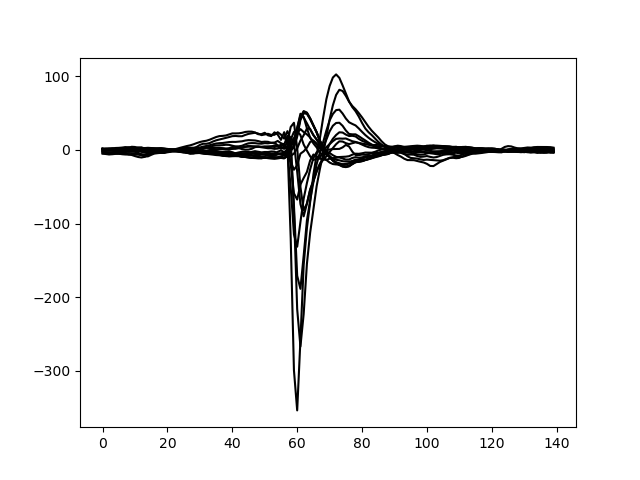

In [110]:
# let's plot a template
fig = plt.figure()
_ = plt.plot(template0, color="k")

In [112]:
# check shapes for all waveforms
for unit in sorting.get_unit_ids():
    wf = we.get_waveforms(unit_id=unit)
    spiketrain = sorting.get_unit_spike_train(unit)
    
    print(f"Unit {unit}: waveform shape - {wf.shape} -- Num spikes: {len(spiketrain)}")

Unit 0: waveform shape - (201, 140, 16) -- Num spikes: 201
Unit 1: waveform shape - (500, 140, 16) -- Num spikes: 1590
Unit 2: waveform shape - (500, 140, 16) -- Num spikes: 2782
Unit 3: waveform shape - (451, 140, 16) -- Num spikes: 451
Unit 4: waveform shape - (500, 140, 16) -- Num spikes: 4594
Unit 5: waveform shape - (219, 140, 16) -- Num spikes: 219
Unit 6: waveform shape - (500, 140, 16) -- Num spikes: 2209
Unit 7: waveform shape - (500, 140, 16) -- Num spikes: 692
Unit 8: waveform shape - (413, 140, 16) -- Num spikes: 413
Unit 9: waveform shape - (500, 140, 16) -- Num spikes: 1174
Unit 10: waveform shape - (500, 140, 16) -- Num spikes: 549
Unit 11: waveform shape - (500, 140, 16) -- Num spikes: 12914
Unit 12: waveform shape - (500, 140, 16) -- Num spikes: 1574
Unit 13: waveform shape - (500, 140, 16) -- Num spikes: 3646
Unit 14: waveform shape - (500, 140, 16) -- Num spikes: 5711
Unit 15: waveform shape - (500, 140, 16) -- Num spikes: 3602
Unit 16: waveform shape - (500, 140, 16

As you can see, there are at most 500 waveforms extracted. To extract waveforms for all spikes, we can use the `max_spikes_per_unit=None` argument:

In [115]:
we_all = si.extract_waveforms(recording_saved, sorting, folder="waveforms_si_all", progress_bar=True,
                          n_jobs=1, total_memory="500M", overwrite=True, max_spikes_per_unit=None)
print(we_all)

extract waveforms: 100%|########################################################################################################################################################################################################################| 1/1 [00:01<00:00,  1.68s/it]


WaveformExtractor: 16 channels - 18 units - 1 segments
  before:60 after80 n_per_units: None


In [116]:
# check shapes for all waveforms
for unit in sorting.get_unit_ids():
    wf = we_all.get_waveforms(unit_id=unit)
    spiketrain = sorting.get_unit_spike_train(unit)
    
    print(f"Unit {unit}: waveform shape - {wf.shape} -- Num spikes: {len(spiketrain)}")

Unit 0: waveform shape - (201, 140, 16) -- Num spikes: 201
Unit 1: waveform shape - (1590, 140, 16) -- Num spikes: 1590
Unit 2: waveform shape - (2782, 140, 16) -- Num spikes: 2782
Unit 3: waveform shape - (451, 140, 16) -- Num spikes: 451
Unit 4: waveform shape - (4594, 140, 16) -- Num spikes: 4594
Unit 5: waveform shape - (219, 140, 16) -- Num spikes: 219
Unit 6: waveform shape - (2209, 140, 16) -- Num spikes: 2209
Unit 7: waveform shape - (692, 140, 16) -- Num spikes: 692
Unit 8: waveform shape - (413, 140, 16) -- Num spikes: 413
Unit 9: waveform shape - (1174, 140, 16) -- Num spikes: 1174
Unit 10: waveform shape - (549, 140, 16) -- Num spikes: 549
Unit 11: waveform shape - (12914, 140, 16) -- Num spikes: 12914
Unit 12: waveform shape - (1574, 140, 16) -- Num spikes: 1574
Unit 13: waveform shape - (3646, 140, 16) -- Num spikes: 3646
Unit 14: waveform shape - (5711, 140, 16) -- Num spikes: 5711
Unit 15: waveform shape - (3602, 140, 16) -- Num spikes: 3602
Unit 16: waveform shape - (3

### Exercise 5b) Find `widgets` for plotting waveforms

Use the `widgets` module to visualize waveform extractor objects

### 5b) SOLUTION

<IPython.core.display.Javascript object>


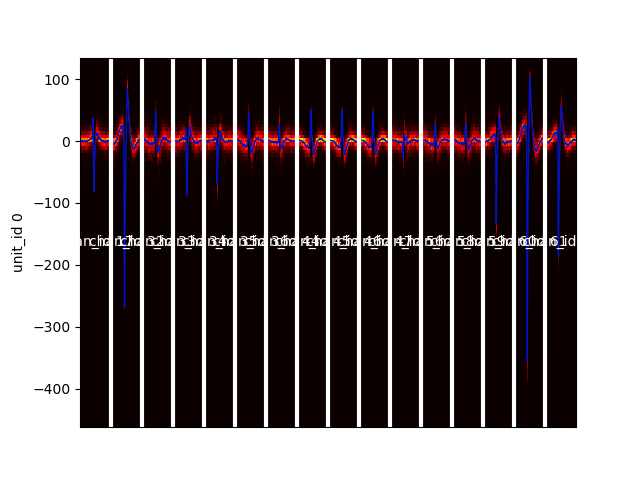

In [122]:
sw.plot_unit_waveform_density_map(we, unit_ids=[0])

<IPython.core.display.Javascript object>


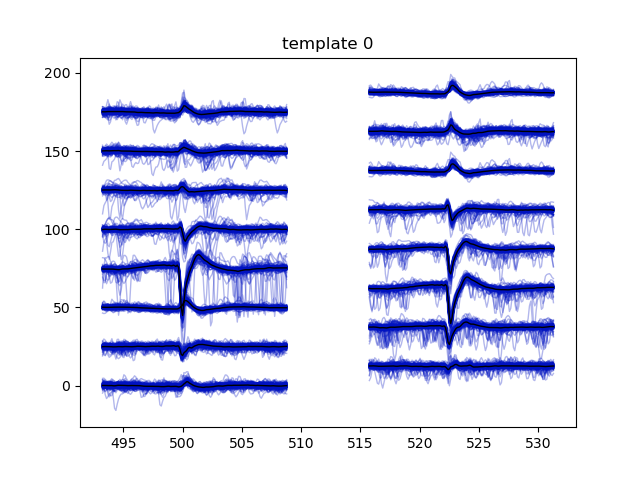

In [123]:
sw.plot_unit_waveforms(we, unit_ids=[0])

<IPython.core.display.Javascript object>


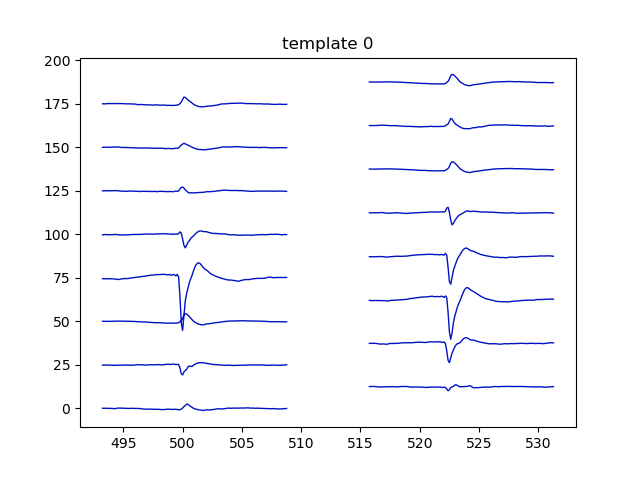

In [124]:
sw.plot_unit_templates(we, unit_ids=[0])

<IPython.core.display.Javascript object>


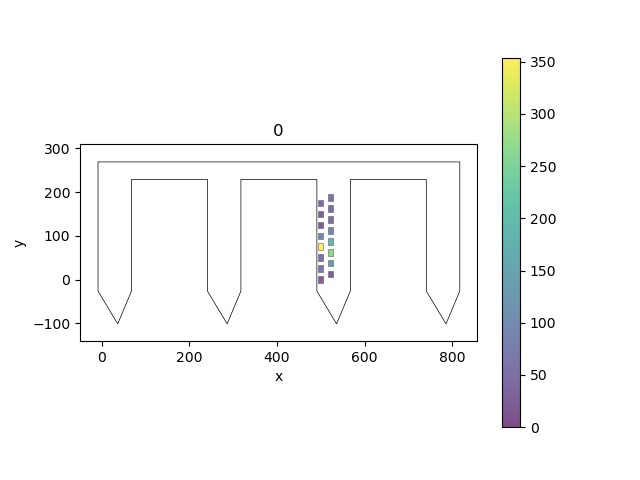

In [125]:
sw.plot_unit_probe_map(we, unit_ids=[0])

<IPython.core.display.Javascript object>


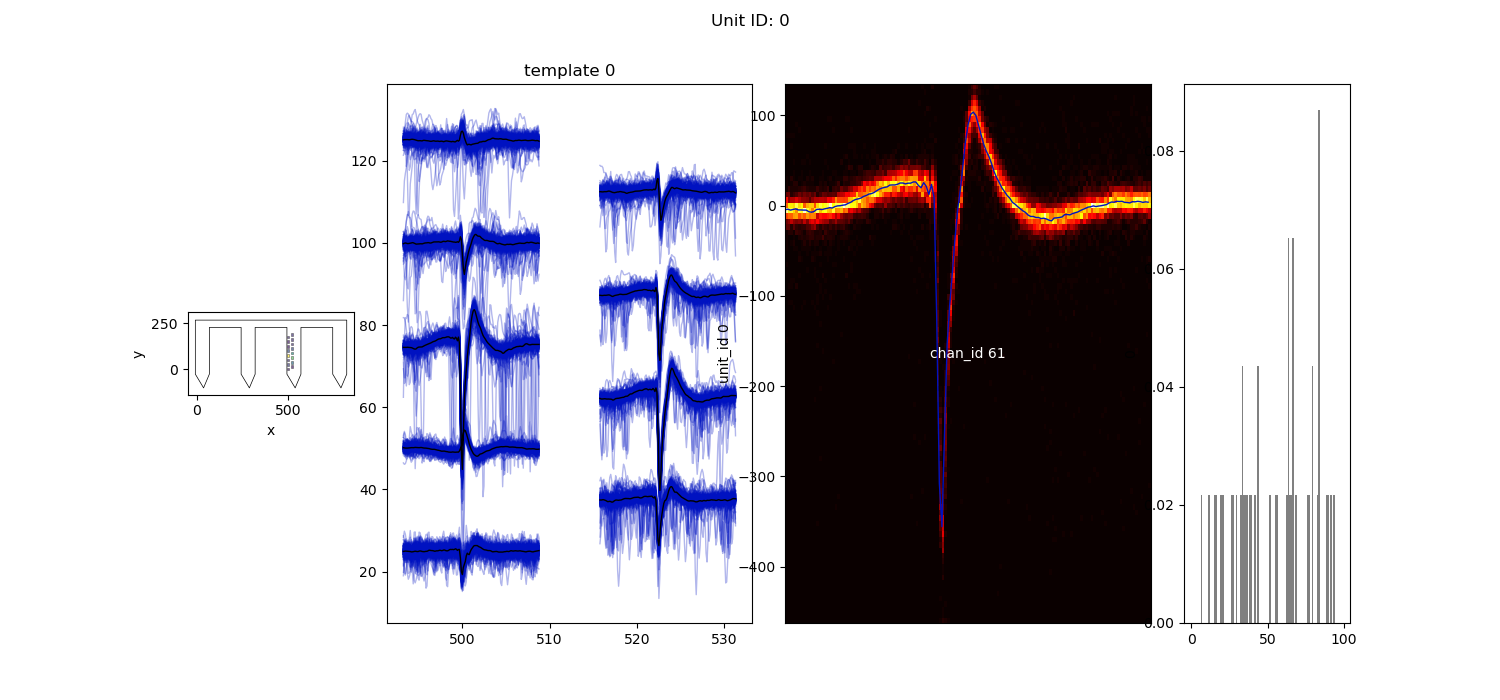

In [127]:
sw.plot_unit_summary(we, unit_id=0)

# 6. Postprocessing <a class="anchor" id="postprocessing"></a>

Postprocessing spike sorting results ranges from computing additional information, such as spike amplitudes and Principal Component Analisys (PCA) scores, to computing features of the extracellular waveforms, similarity between templates and crosscorrelograms. All of this is possible with the `toolkit` module.

### PCA scores

PCA scores can be easily computed with the `compute_principal_components()` function. Similarly to the `extract_waveforms`, the function returns an object of type `WaveformPrincipalComponent` that allows to retrieve all pc scores on demand.

In [128]:
pc = st.compute_principal_components(we, n_components=3)

In [129]:
pc0 = pc.get_components(unit_id=0)
all_labels, all_pcs = pc.get_all_components()

For pc scores of a single unit, the dimension is (num_spikes, num_components, num_channels). 
The `get_all_components()` function returns an array with the label/unit id for each component (`all_labels`) and an array of dimension (num_all_samples, num_components, num_channels). 

**IMPORTANT**: The `get_components()` and `get_all_components()` will be renamed `get_projections()` and `get_all_projections()` in the next release.

### Spike amplitudes

Spike amplitudes can be computed with the `get_spike_amplitudes` function.

In [143]:
amplitudes = st.get_spike_amplitudes(we, outputs="concatenated", progress_bar=True)[0]

extract amplitudes: 100%|#######################################################################################################################################################################################################################| 1/1 [00:00<00:00,  1.15it/s]


By default, all amplitudes are concatenated in one array.

The correspinding spike times and labels can be easily retrieved as:

In [131]:
all_spike_times, all_spike_labels = sorting.get_all_spike_trains()[0]

The [0] index is to select the first segment. In case of multiple segments each element will correspond to a different segment and will contain spike times and labels for that segment.


### Exercise 6a) Plot pca projections and amplitudes over time

Explore the principal component space and amplitudes using `matplotlib`

- Plot projections of two units on multiple channels and pc components
- Plot the spike amplitudes of a unit over time

### 6a) SOLUTION

<IPython.core.display.Javascript object>


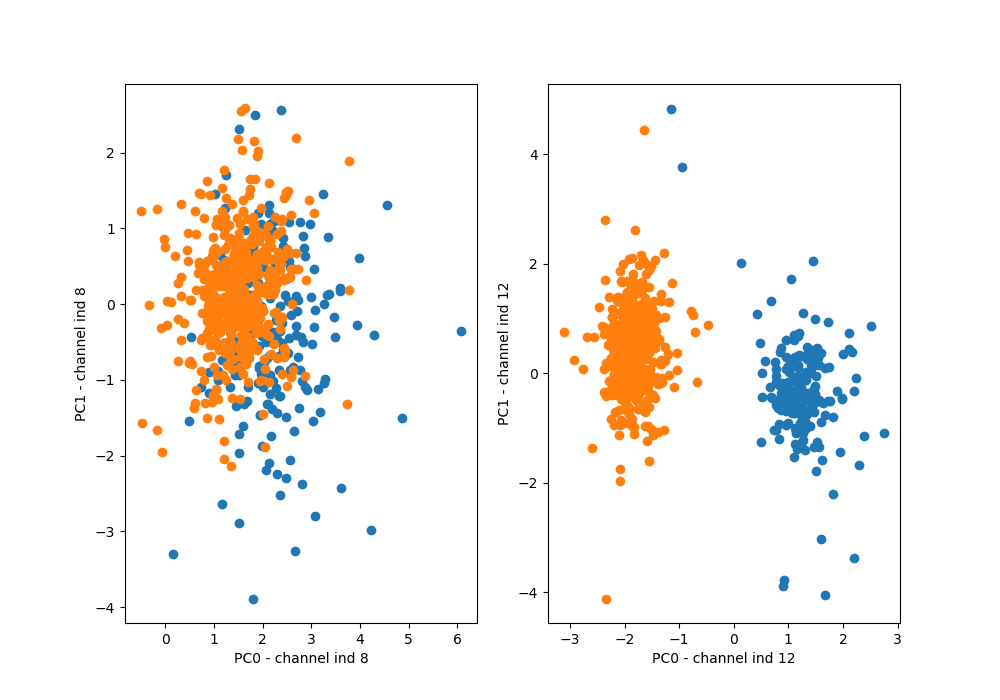

Text(0, 0.5, 'PC1 - channel ind 12')

In [139]:
# Explore pc and amplitudes
pc0 = pc.get_components(unit_id=0)
pc1 = pc.get_components(unit_id=1)


fig, axs = plt.subplots(ncols=2, figsize=(10,7))

# let's plot the projections on the first 2 components choose 2 channel indices
channel_ind1 = 8
channel_ind2 = 12


axs[0].scatter(pc0[:, 0, channel_ind1], pc0[:, 1, channel_ind1])
axs[0].scatter(pc1[:, 0, channel_ind1], pc1[:, 1, channel_ind1])
axs[0].set_xlabel(f"PC0 - channel ind {channel_ind1}")
axs[0].set_ylabel(f"PC1 - channel ind {channel_ind1}")

axs[1].scatter(pc0[:, 0, channel_ind2], pc0[:, 1, channel_ind2])
axs[1].scatter(pc1[:, 0, channel_ind2], pc1[:, 1, channel_ind2])
axs[1].set_xlabel(f"PC0 - channel ind {channel_ind2}")
axs[1].set_ylabel(f"PC1 - channel ind {channel_ind2}")

In [151]:
amplitudes_unit0 = amplitudes[all_spike_labels == 0]
spiketrain_unit0 = sorting.get_unit_spike_train(0) / sorting.get_sampling_frequency()

amplitudes_unit1 = amplitudes[all_spike_labels == 1]
spiketrain_unit1 = sorting.get_unit_spike_train(1) / sorting.get_sampling_frequency()

<>:7: DeprecationWarning: invalid escape sequence \m
<>:7: DeprecationWarning: invalid escape sequence \m
/var/folders/vl/0vmqjsjn0dg8ycnxdx_mqrdw0000gr/T/ipykernel_82318/3570712718.py:7: DeprecationWarning: invalid escape sequence \m
  ax.set_ylabel(f"amplitude ($\mu$V)")


<IPython.core.display.Javascript object>


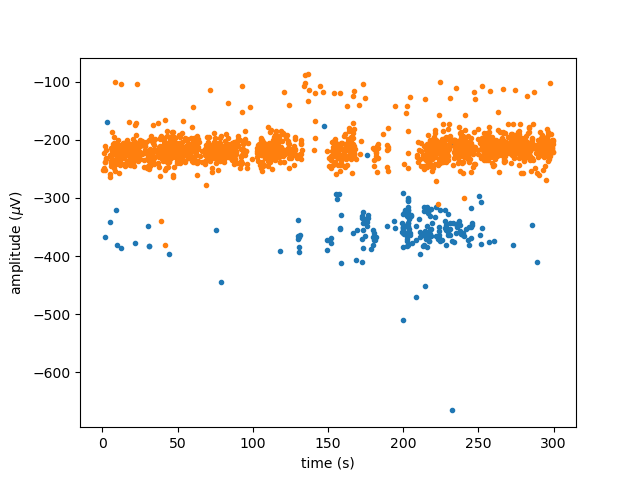

Text(0, 0.5, 'amplitude ($\\mu$V)')

In [157]:
fig, ax = plt.subplots()

ax.plot(spiketrain_unit0, amplitudes_unit0, ls="", marker=".")
ax.plot(spiketrain_unit1, amplitudes_unit1, ls="", marker=".")

ax.set_xlabel(f"time (s)")
ax.set_ylabel(f"amplitude ($\mu$V)")

### Compute template metrics

Template metrics, or extracellular features, such as peak to valley duration or full-width half maximum, are important to classify neurons into putative classes (excitatory - inhibitory). The `toolkit` allows one to compute several of these metrics:

In [158]:
print(st.get_template_metric_names())

['peak_to_valley', 'peak_trough_ratio', 'half_width', 'repolarization_slope', 'recovery_slope']


In [159]:
template_metrics = st.calculate_template_metrics(we)
display(template_metrics)

peak_to_valley peak_trough_ratio half_width repolarization_slope  \
0          0.0006         -0.290188     0.0002       1127392.174176   
1         0.00055         -0.310358    0.00025        672440.081324   
2          0.0002         -0.304361     0.0002        3077326.24054   
3          0.0006         -0.296026    0.00025        517805.440085   
4         0.00065         -0.258527    0.00025        448332.817214   
5          0.0007         -0.272413    0.00025        396130.764598   
6         0.00025         -0.303449     0.0002       1195236.625671   
7          0.0006         -0.287252     0.0003        210452.314615   
8          0.0006         -0.274734    0.00025        478632.230418   
9         0.00065         -0.267566    0.00025        230075.667926   
10         0.0007         -0.264495    0.00025        341298.742612   
11        0.00025         -0.315719     0.0002       1048830.184937   
12        0.00025          -0.30441    0.00025        468549.995422   
13         0.0007         -0.249576     0.0003        187295.326619   
14        0.00055         -0.208558    0.00025        148271.856308   
15        0.00025         -0.099796     0.0002        612756.848335   
16         0.0005         -0.137561     0.0002          236183.3148   
17        0.00025         -0.140985     0.0002        452201.734543   

   recovery_slope  
0  -146445.763934  
1  -100099.086342  
2  -137869.400779  
3   -70910.286034  
4   -60675.857209  
5   -56144.033547  
6   -57923.776019  
7   -25938.192263  
8   -52789.314396  
9   -31328.594124  
10  -50637.207115  
11  -57633.800653  
12  -26399.899891  
13  -23092.523365  
14  -10314.926829  
15   -3526.969826  
16   -4708.168255  
17   -3246.081153

For more information about these template metrics, we refer to this [documentation](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms) from the Allen Institute.

# 7. Viewers <a class="anchor" id="viewers"></a>

The `spikeinterface-gui` allows you to interactively explore a spike sorting output once waveforms are extracted.


### Exercise 7a) Use the `spikeinterface-gui` to epxlore the sorting output

Launch the `sigui` on the waveforms folder and explore all different views.

- Can you find some bad units?
- Are there missed spikes or spike sorting errors?

In [160]:
!sigui waveforms_si

/Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/forks/alejoe91/spikeinterface/spikeinterface/core/baserecording.py:330: UserWarning: There is no Probe attached to this recording. Creating a dummy one with contact positions
  warn('There is no Probe attached to this recording. Creating a dummy one with contact positions')


![alt text](sigui.png "SI-GUI")

# 8. Validation and curation <a class="anchor" id="curation"></a>

The `toolkit` module also provides several functions to compute qualitity metrics to validate the spike sorting results.

Let's see what metrics are available:

In [161]:
print(st.get_quality_metric_list())

['num_spikes', 'firing_rate', 'presence_ratio', 'snr', 'isi_violation', 'amplitude_cutoff']


In [162]:
qc = st.compute_quality_metrics(we_all, waveform_principal_component=pc)

In [163]:
display(qc)

num_spikes  firing_rate  presence_ratio        snr  isi_violations_rate  \
0          201     0.670000            0.47  51.018700             0.000000   
1         1590     5.300000            0.98  26.594860             0.003333   
2         2782     9.273333            1.00  49.792995             0.000000   
3          451     1.503333            0.84  24.339945             0.003333   
4         4594    15.313333            1.00  24.253412             0.106667   
5          219     0.730000            0.64  15.909021             0.003333   
6         2209     7.363333            0.99  22.447401             0.013333   
7          692     2.306667            0.92   9.570136             0.030000   
8          413     1.376667            0.77  16.373022             0.010000   
9         1174     3.913333            0.98  12.157477             0.016667   
10         549     1.830000            0.71  15.341343             0.000000   
11       12914    43.046667            1.00  17.437460             1.670000   
12        1574     5.246667            1.00   7.768877             0.183333   
13        3646    12.153333            1.00   7.799982             0.270000   
14        5711    19.036667            1.00   6.151381             0.703333   
15        3602    12.006667            1.00   9.837802             0.150000   
16        3290    10.966667            1.00   5.501307             0.566667   
17        6188    20.626667            1.00   7.311756             0.336667   

    isi_violations_count  amplitude_cutoff  isolation_distance   l_ratio  \
0                      0          0.028174          188.838651  0.013088   
1                      1          0.016412          223.896685  0.000659   
2                      0          0.000667          538.045397  0.046462   
3                      1          0.000574          136.618522  0.059987   
4                     32          0.000056          155.526651  0.006852   
5                      1          0.001182           72.039735  0.118340   
6                      4          0.000117          138.522306  0.014836   
7                      9          0.000374           36.180449  2.622866   
8                      3          0.074049           70.172485  0.146679   
9                      5          0.000220           67.973372  0.258182   
10                     0          0.000471          121.281162  0.040760   
11                   501          0.000020          114.717020  0.028514   
12                    55          0.000164           42.309685  1.717164   
13                    81          0.000071           51.530178  0.853350   
14                   211          0.000724           40.684133  1.891353   
15                    45          0.002201           59.541900  0.474115   
16                   170          0.000079           34.988829  2.600593   
17                   101          0.000042           80.895926  0.112656   

      d_prime  
0    8.468891  
1    8.965578  
2   11.053776  
3    6.397198  
4    6.801467  
5    4.725245  
6    7.826088  
7    2.257253  
8    5.995062  
9    4.088156  
10   5.270453  
11   5.500054  
12   3.307515  
13   2.584634  
14   1.675418  
15   2.399901  
16   1.704189  
17   4.263573

For more information about these waveform features, we refer to this [documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html) from the Allen Institute.

## Automatic curation based on quality metrics

A viable option to curate (or at least pre-curate) a spike sorting output is to filter units based on quality metrics. As we have already computed quality metrics a few lines above, we can simply filter the `qc` dataframe based on some thresholds.

Here, we'll only keep units with an SNR > 5 and an ISI violation threshold < 0.2:

In [164]:
snr_thresh = 5
isi_viol_thresh = 0.2

A straightforward way to filter a pandas dataframe is via the `query`.
We first define our query (make sure the names match the column names of the dataframe):

In [165]:
our_query = f"snr > {snr_thresh} & isi_violations_rate < {isi_viol_thresh}"
print(our_query)

snr > 5 & isi_violations_rate < 0.2


and then we can use the query to select units:

In [166]:
keep_units = qc.query(our_query)
keep_unit_ids = keep_units.index.values

In [167]:
sorting_auto = sorting.select_units(keep_unit_ids)
print(f"Number of units before curation: {len(sorting.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto.get_unit_ids())}")

Number of units before curation: 18
Number of units after curation: 13


### 8a) Extract waveforms on the curated sorting and explore the output in the spikeinterface-gui

Re-extract waveforms using the curated output and explore the results.

Is the spike sorting quality improved?

### 8a) SOLUTION



In [168]:
# choose a different folder!
we_curated = si.extract_waveforms(recording_saved, sorting_auto, folder="waveforms_si_curated", progress_bar=True,
                                  n_jobs=1, total_memory="500M", overwrite=True)
print(we_curated)

extract waveforms: 100%|########################################################################################################################################################################################################################| 1/1 [00:00<00:00,  1.02it/s]

WaveformExtractor: 16 channels - 13 units - 1 segments
  before:60 after80 n_per_units: 500


In [169]:
!sigui waveforms_si_curated

/Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/forks/alejoe91/spikeinterface/spikeinterface/core/baserecording.py:330: UserWarning: There is no Probe attached to this recording. Creating a dummy one with contact positions
  warn('There is no Probe attached to this recording. Creating a dummy one with contact positions')


### 8b) Explore different curation strategies in the spikeinterface-gui

- Try to use different thresholds and/or quality metrics to automatically curate the spike sorting output.
- View the result in the `spikeinterface-gui`

### 8b) SOLUTION

We can try to be more strict in pur thresholds:

In [171]:
snr_thresh_strict = 8
isi_viol_thresh_strict = 0.05

In [172]:
our_query_strict = f"snr > {snr_thresh_strict} & isi_violations_rate < {isi_viol_thresh_strict}"
print(our_query_strict)

snr > 8 & isi_violations_rate < 0.05


In [173]:
keep_units_strict = qc.query(our_query_strict)
keep_unit_ids_strict = keep_units_strict.index.values

In [174]:
sorting_auto_strict = sorting.select_units(keep_unit_ids_strict)
print(f"Number of units before curation: {len(sorting.get_unit_ids())}")
print(f"Number of units after strict curation: {len(sorting_auto_strict.get_unit_ids())}")

Number of units before curation: 18
Number of units after strict curation: 10


# 9. Exporters <a class="anchor" id="exporters"></a>

The `exporters` module provides functions to export the spike sorting results to different frameworks.

## Export to Phy for manual curation

To perform manual curation we can export the data to [Phy](https://github.com/cortex-lab/phy). 

In [175]:
from spikeinterface.exporters import export_to_phy

In [176]:
export_to_phy(we_curated, output_folder='phy',
              progress_bar=True, total_memory='100M')

write_binary_recording with n_jobs 1  chunk_size 3125000


extract PCs: 100%|##############################################################################################################################################################################################################################| 2/2 [00:22<00:00, 11.24s/it]

Run:
phy template-gui  /Users/abuccino/Documents/Codes/teaching/school_spike_sorting_lyon_2021/Practice_2_spikeinterface_pipeline/phy/params.py


In [177]:
%%capture --no-display
!phy template-gui phy/params.py

![alt text](phy.png "PHY")

After curating the results we can reload it using the `PhySortingExtractor` and exclude the units that we labeled as `noise`:

In [179]:
sorting_phy_curated = se.PhySortingExtractor('phy/', exclude_cluster_groups=['noise'])

In [182]:
print(f"Number of units before curation: {len(sorting_auto.get_unit_ids())}")

# Manually labeled 3 units as noise
print(f"Number of units after curation: {len(sorting_phy_curated.get_unit_ids())}")

Number of units before curation: 13
Number of units after curation: 10


## Export spike sorting report

The SpikeInterface report automatically saves summary and unit-specific views to save and inspect your spike sorting output.

In [183]:
from spikeinterface.exporters import export_report

<IPython.core.display.Javascript object>


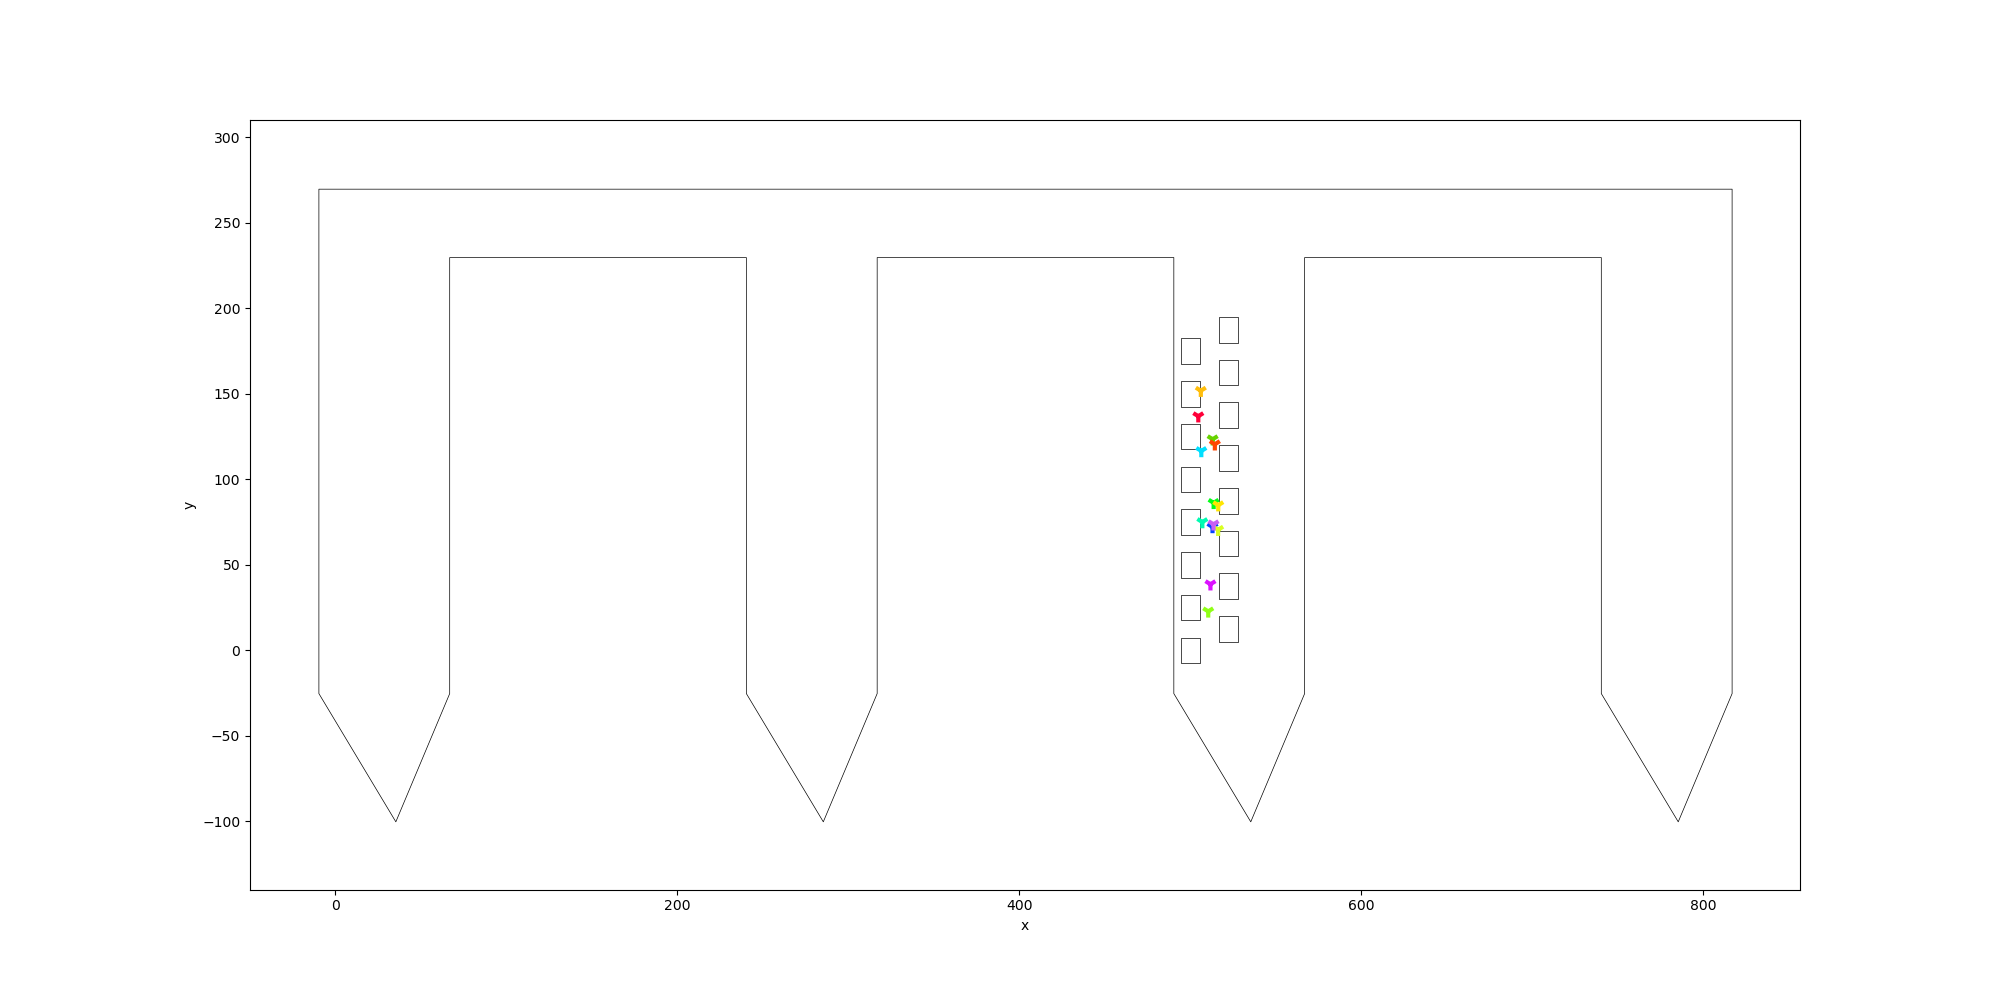

<IPython.core.display.Javascript object>


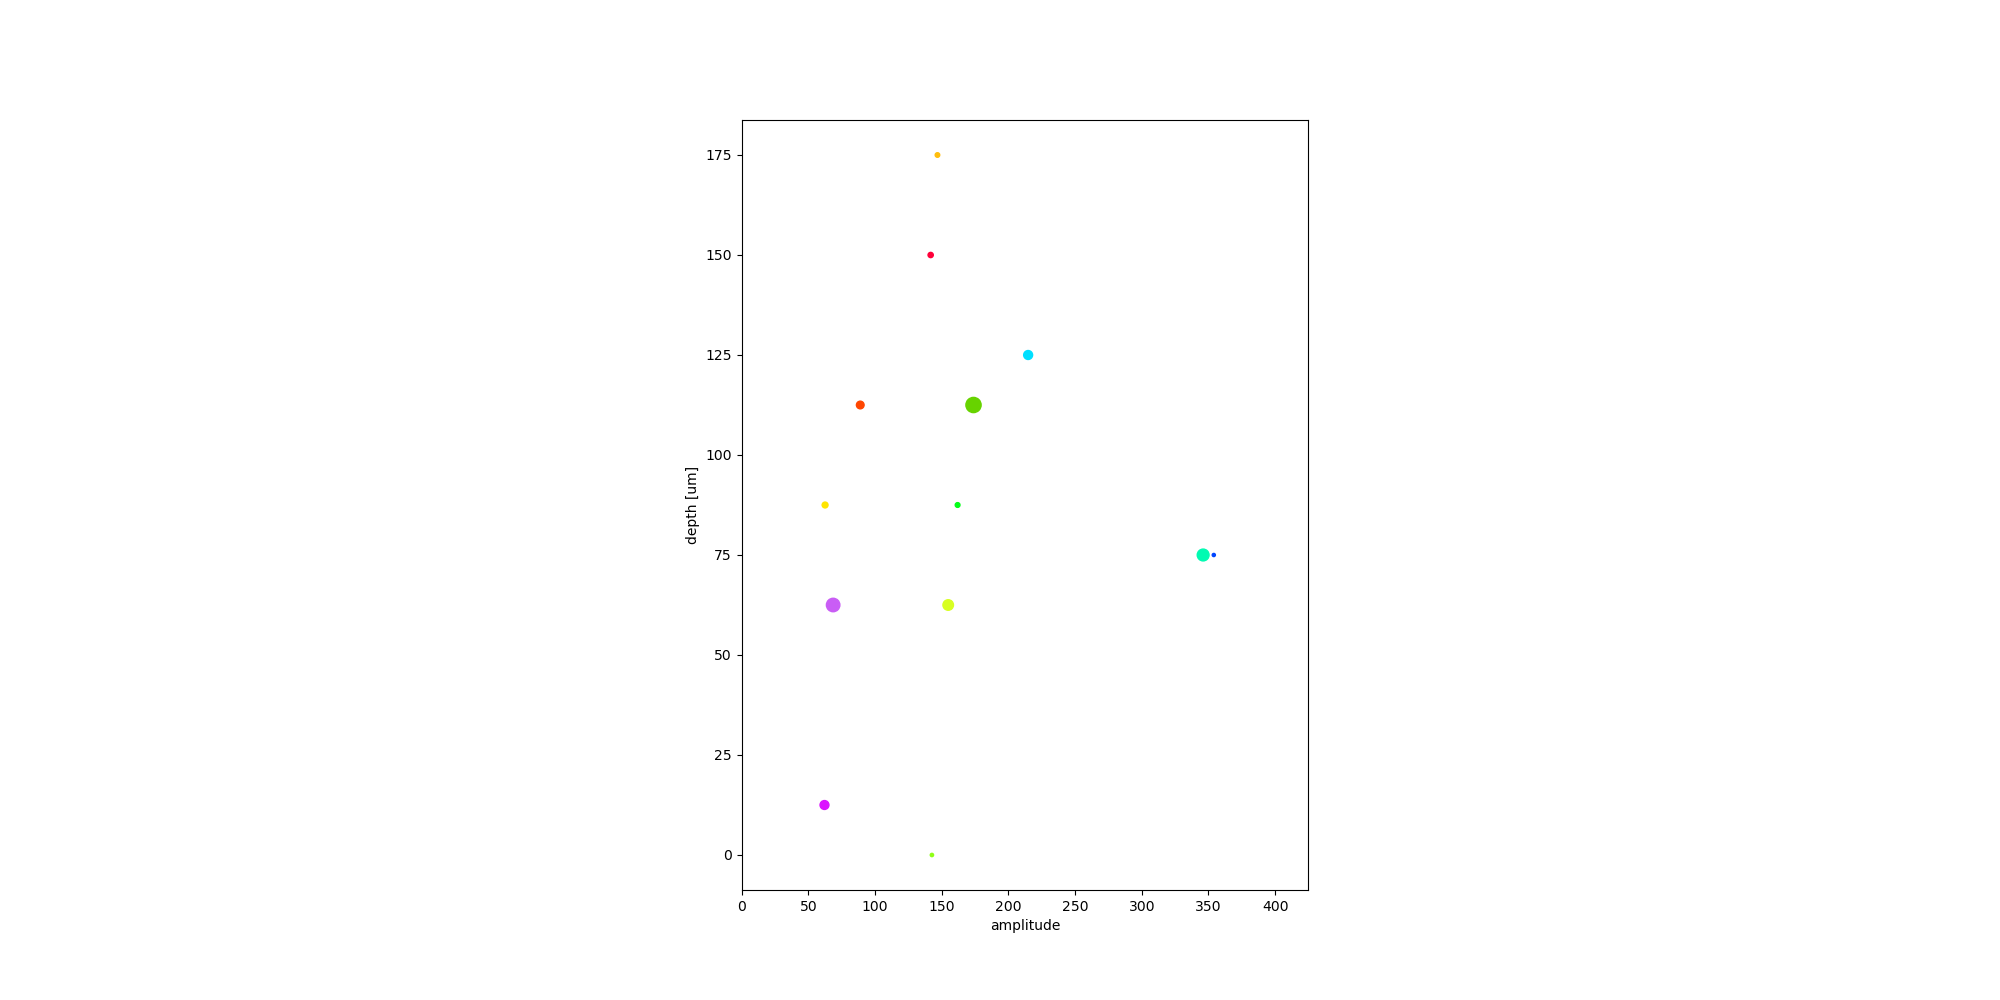

<IPython.core.display.Javascript object>


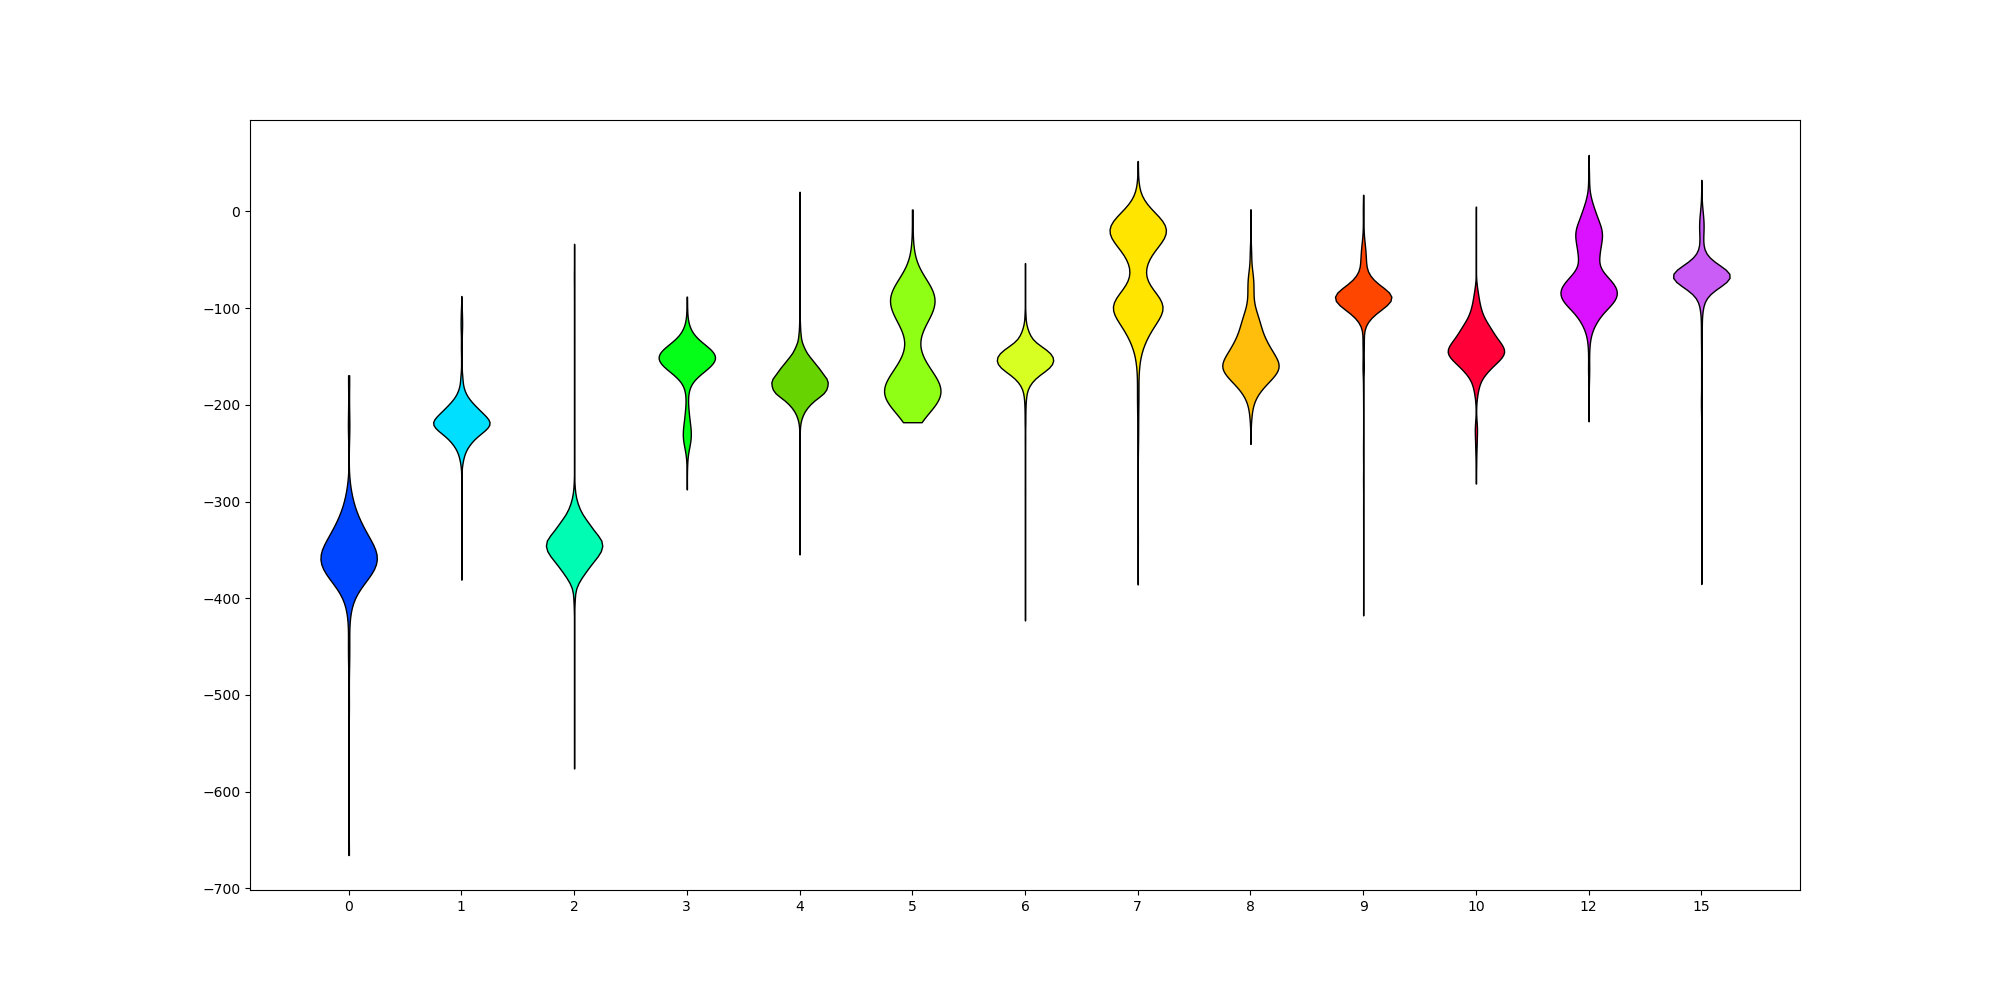

<IPython.core.display.Javascript object>


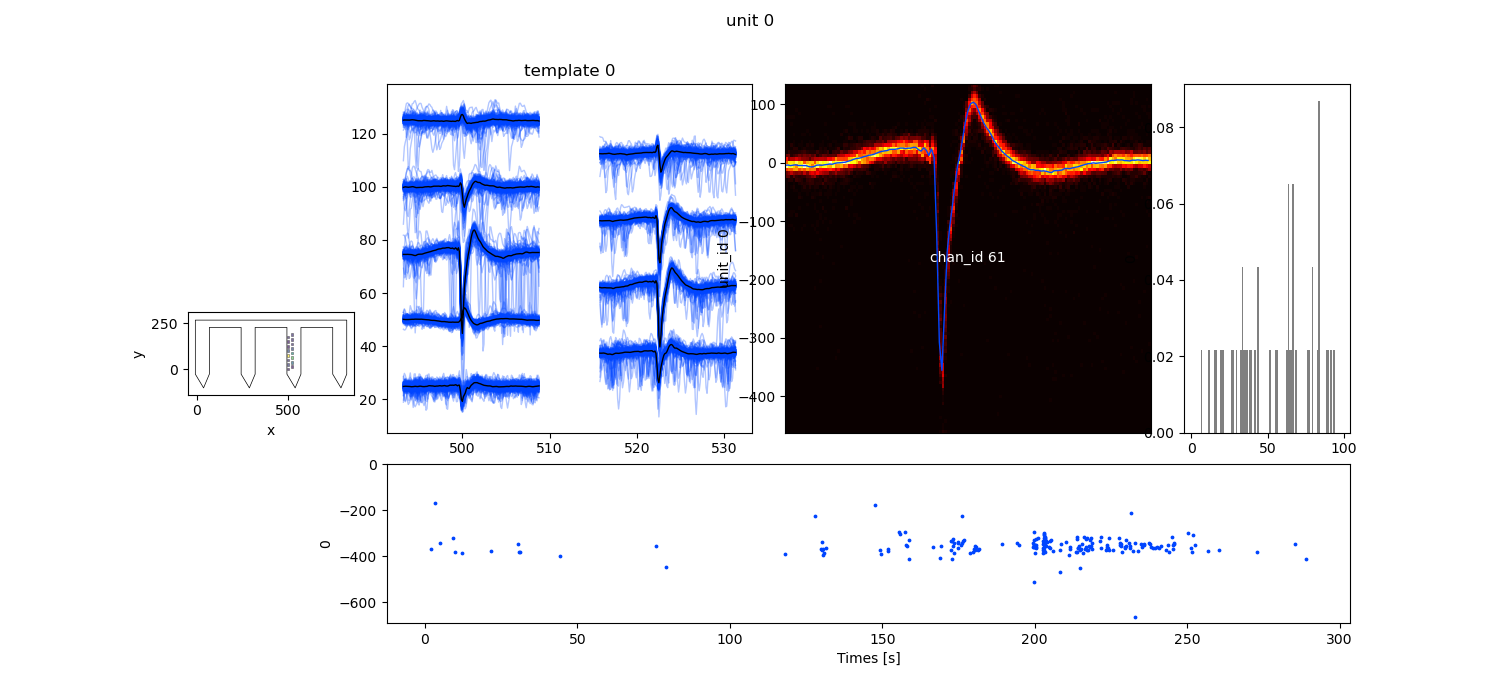

/Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/forks/alejoe91/spikeinterface/spikeinterface/exporters/report.py:89: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(constrained_layout=False, figsize=(15, 7), )


<IPython.core.display.Javascript object>


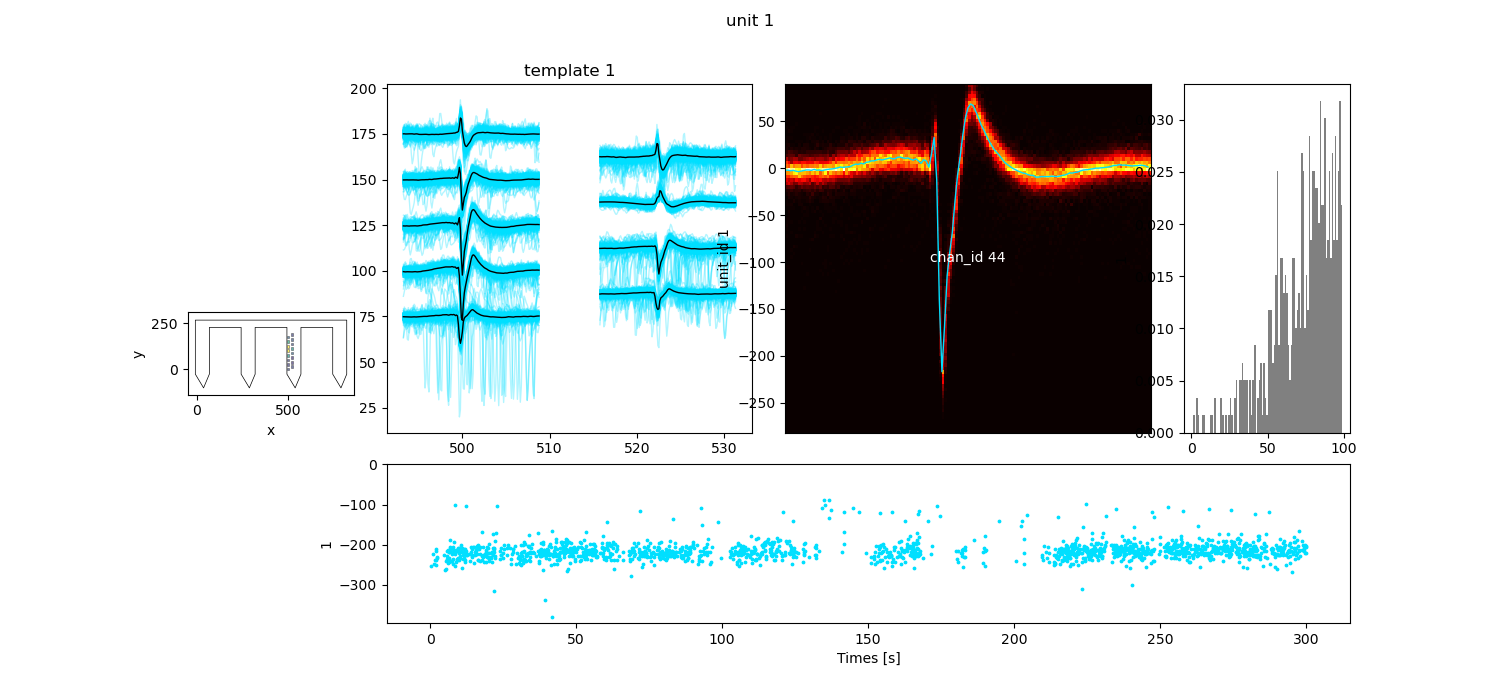

<IPython.core.display.Javascript object>


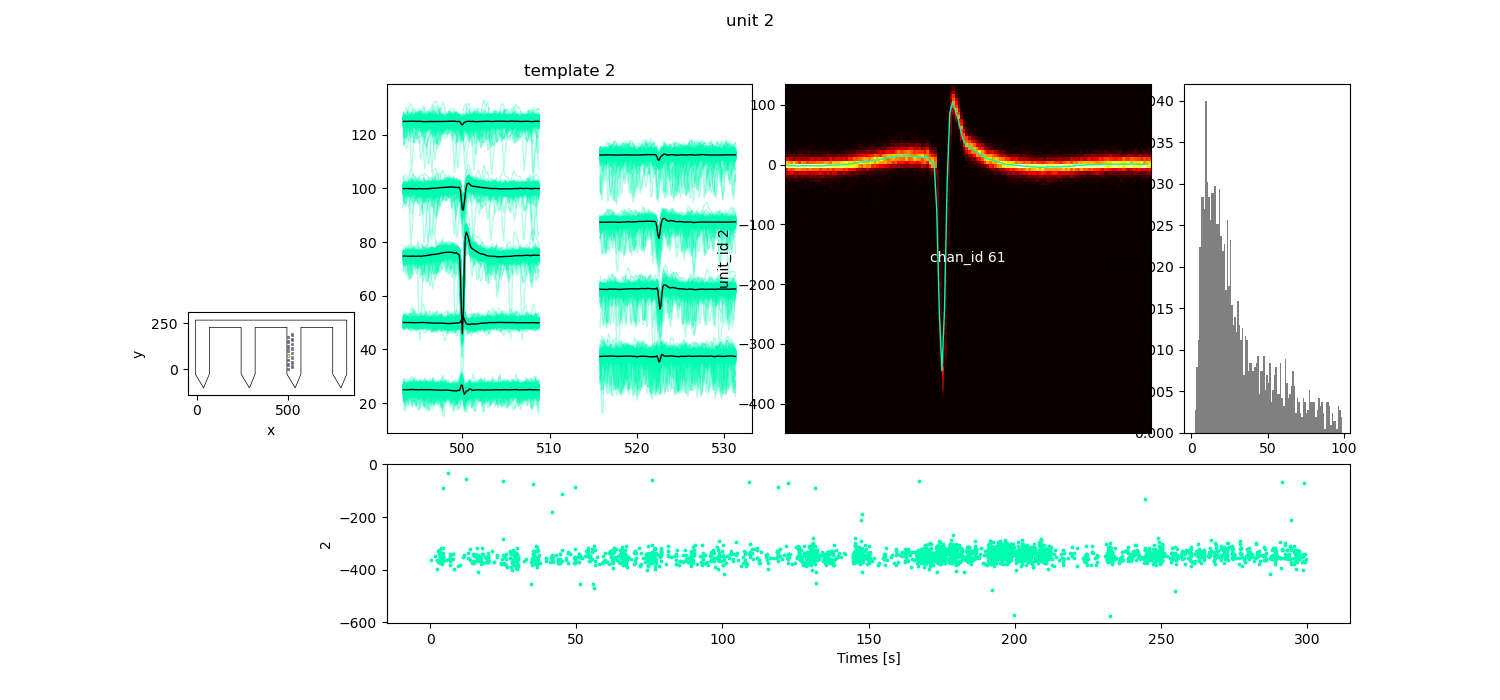

<IPython.core.display.Javascript object>


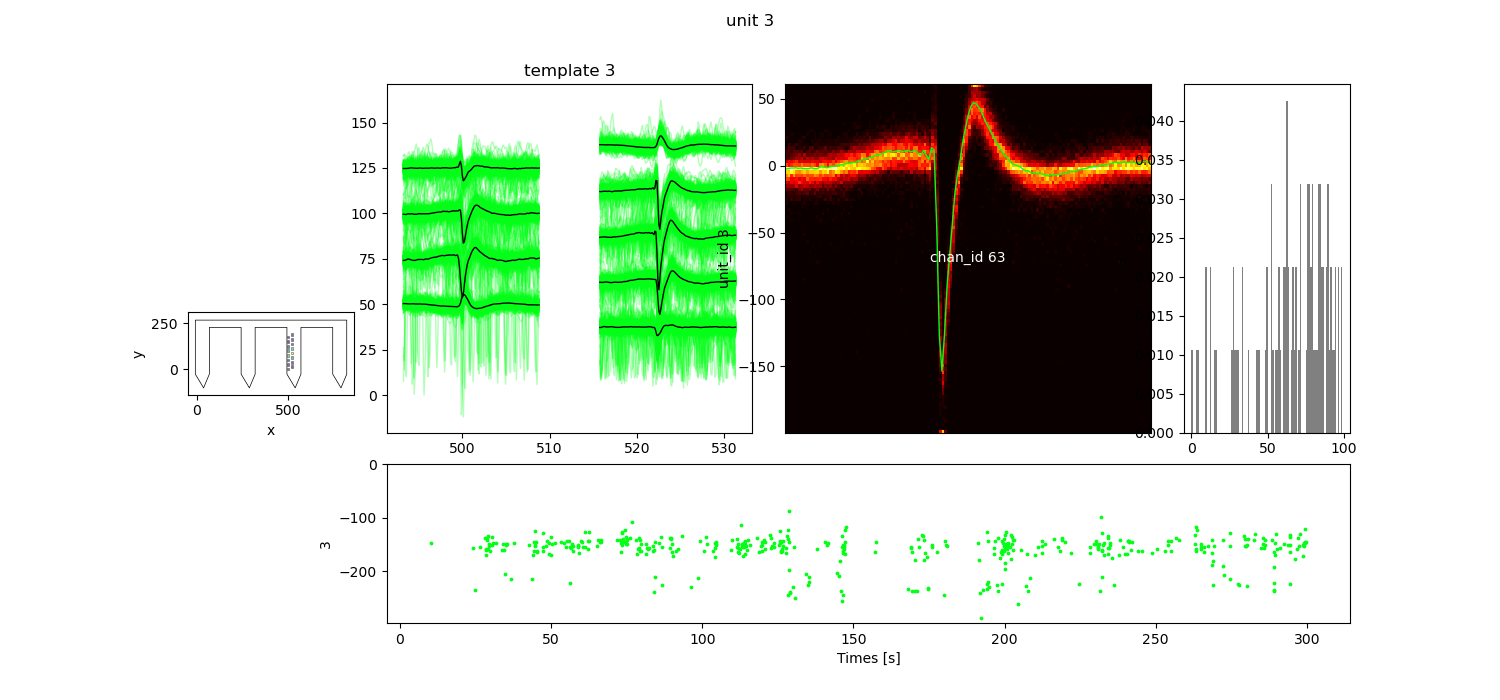

<IPython.core.display.Javascript object>


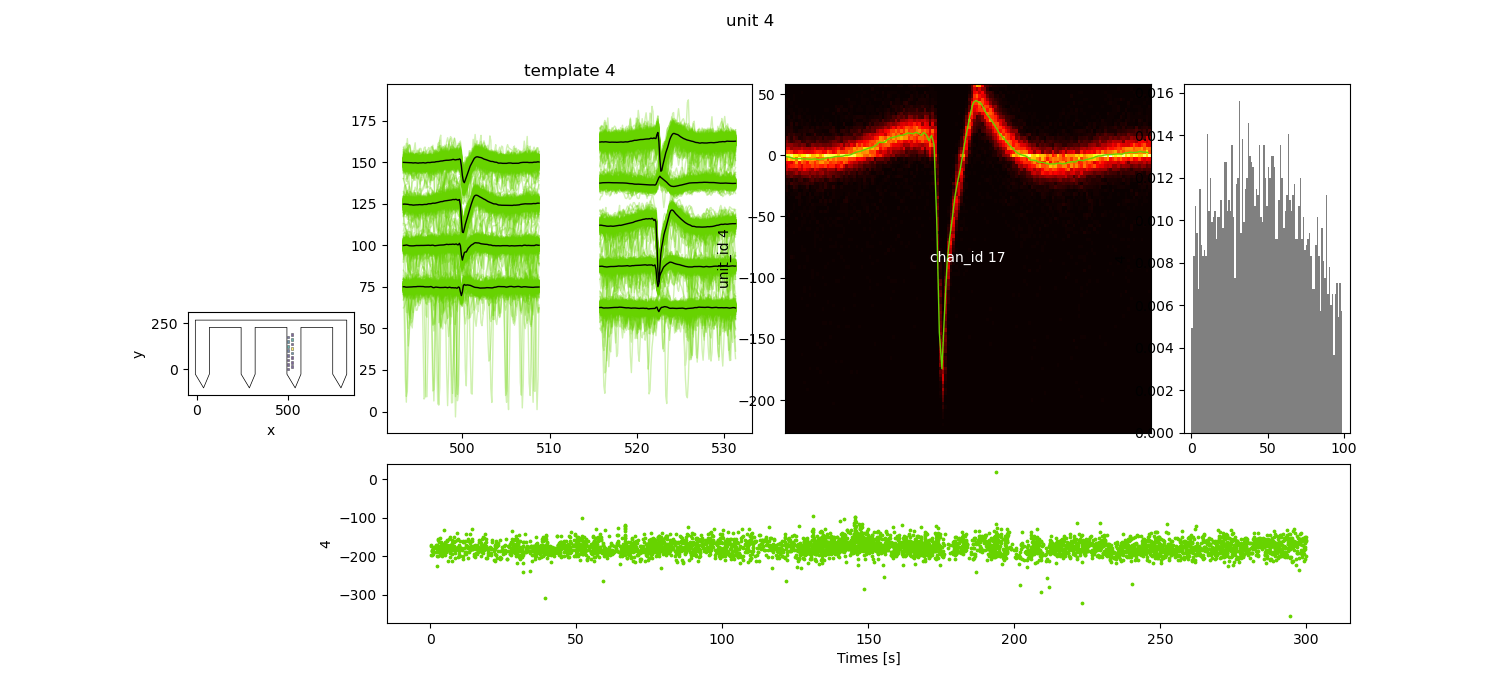

<IPython.core.display.Javascript object>


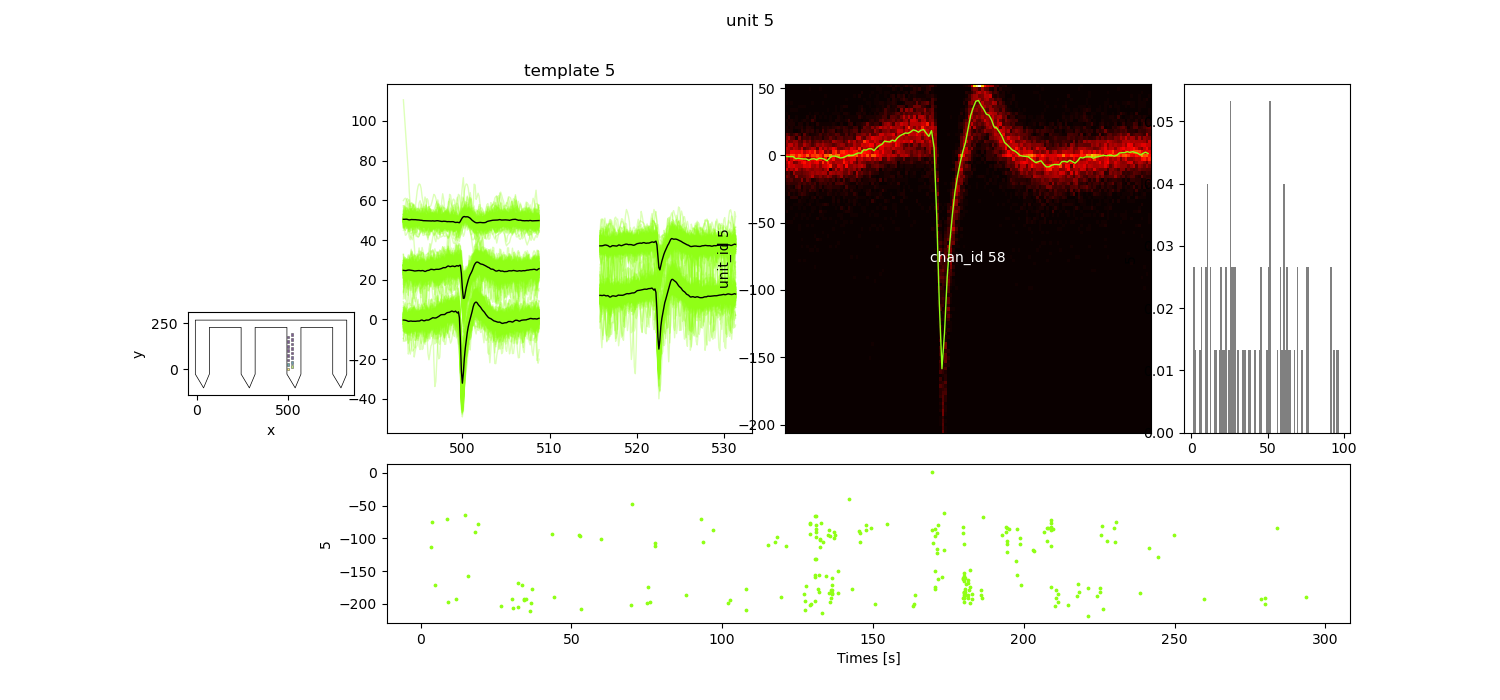

<IPython.core.display.Javascript object>


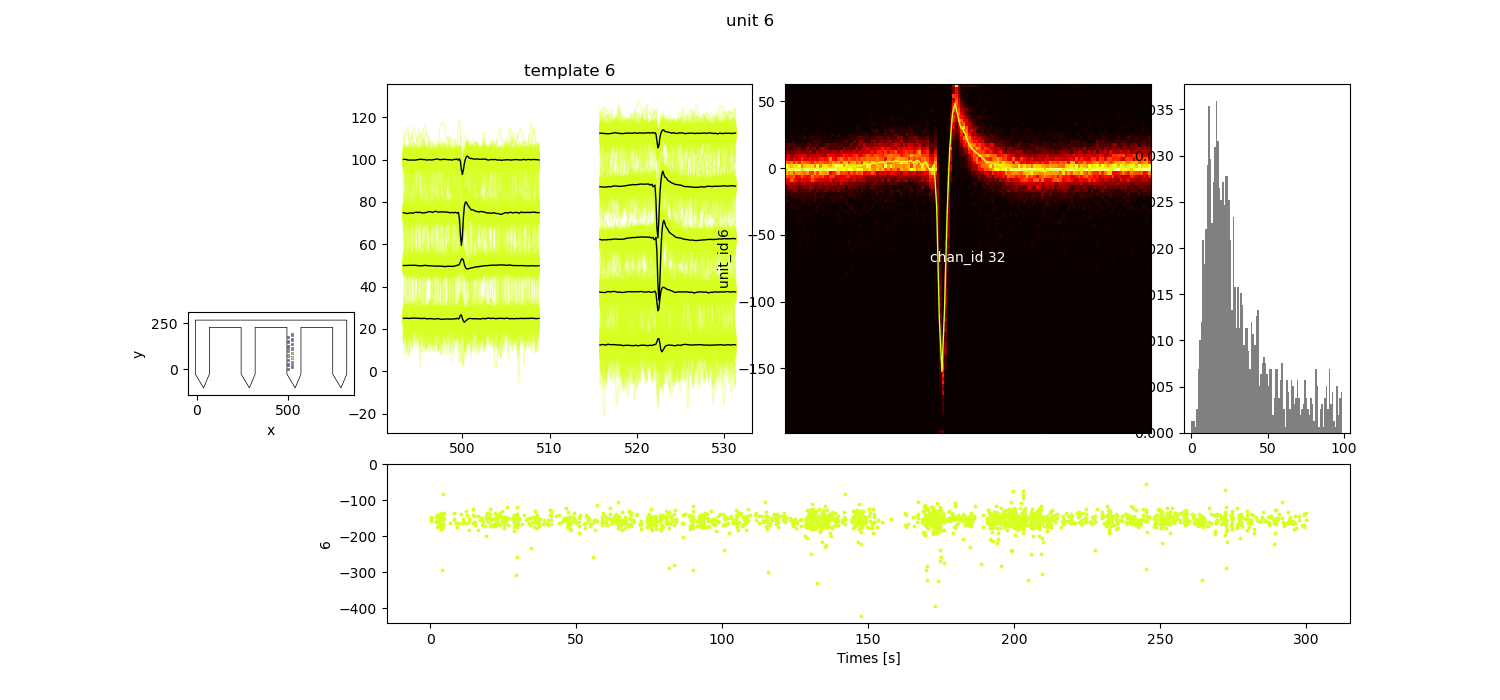

<IPython.core.display.Javascript object>


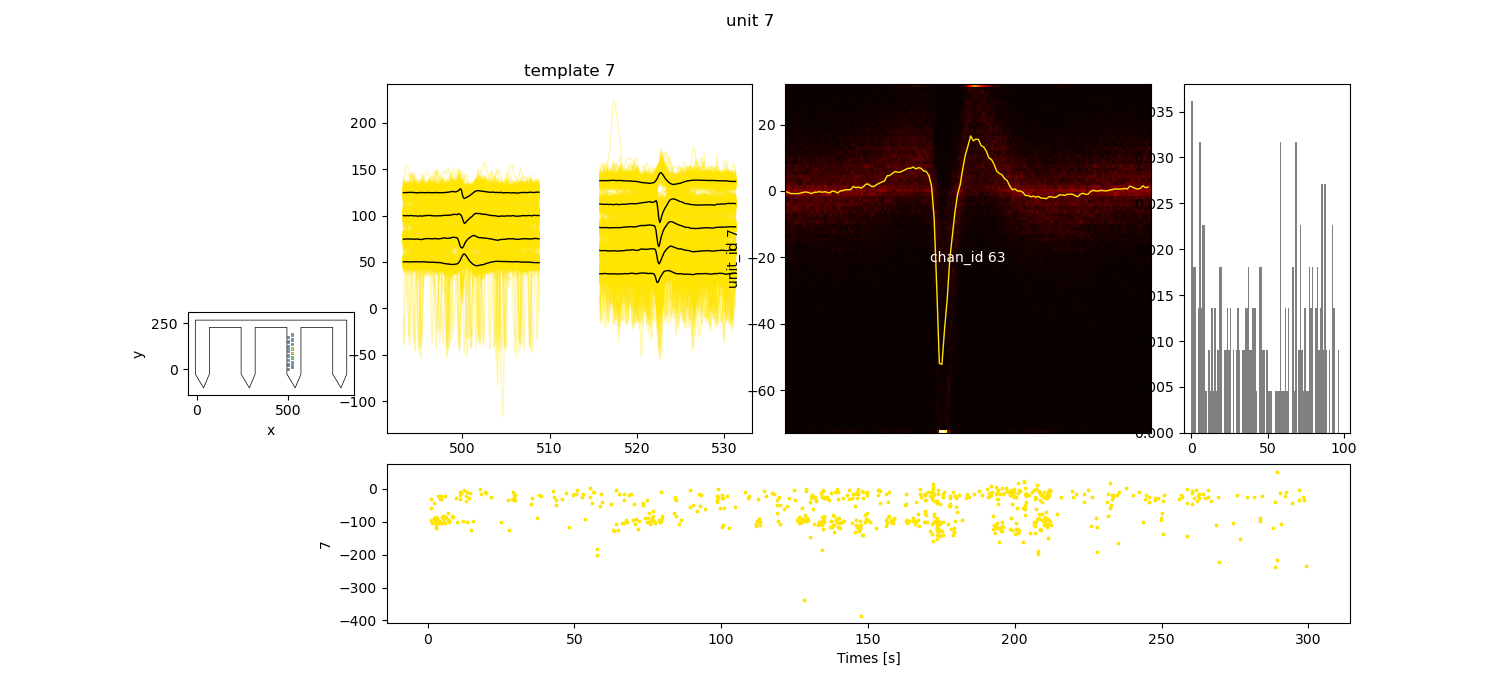

<IPython.core.display.Javascript object>


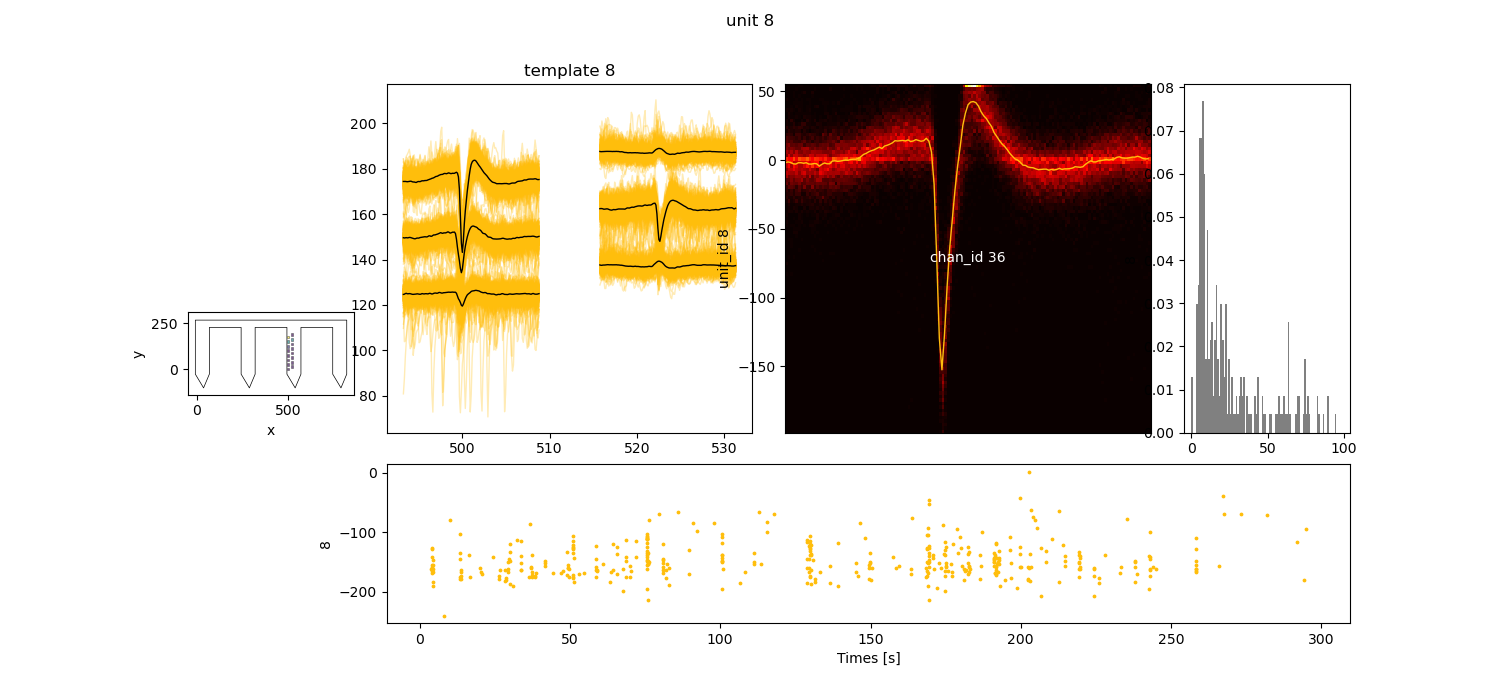

<IPython.core.display.Javascript object>


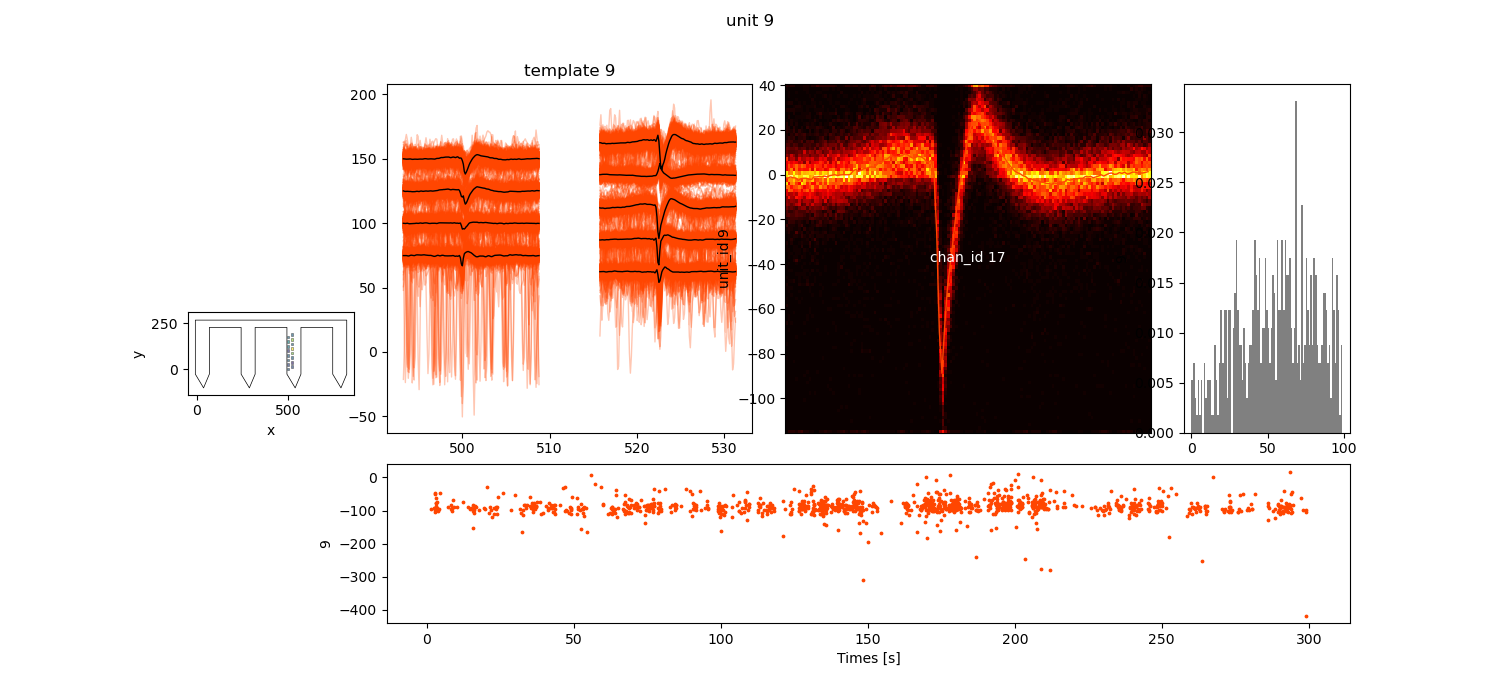

<IPython.core.display.Javascript object>


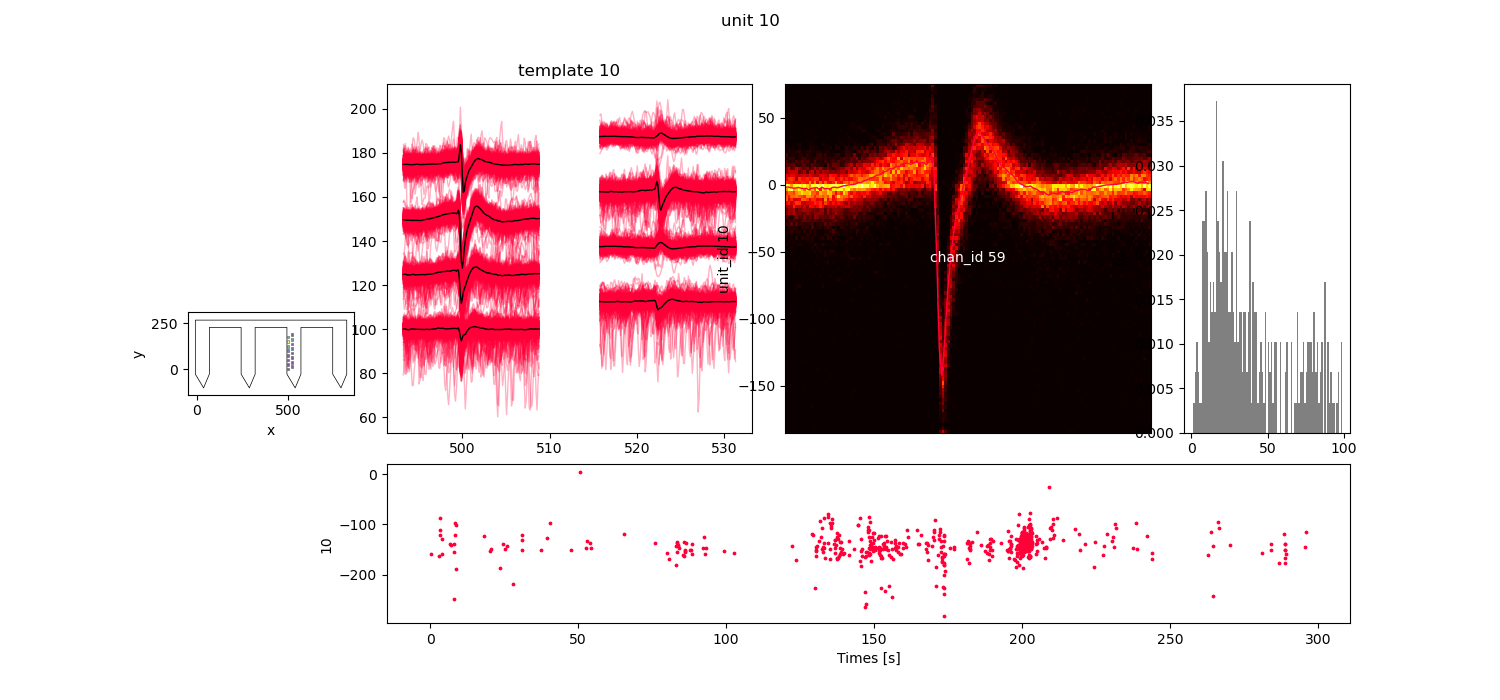

<IPython.core.display.Javascript object>


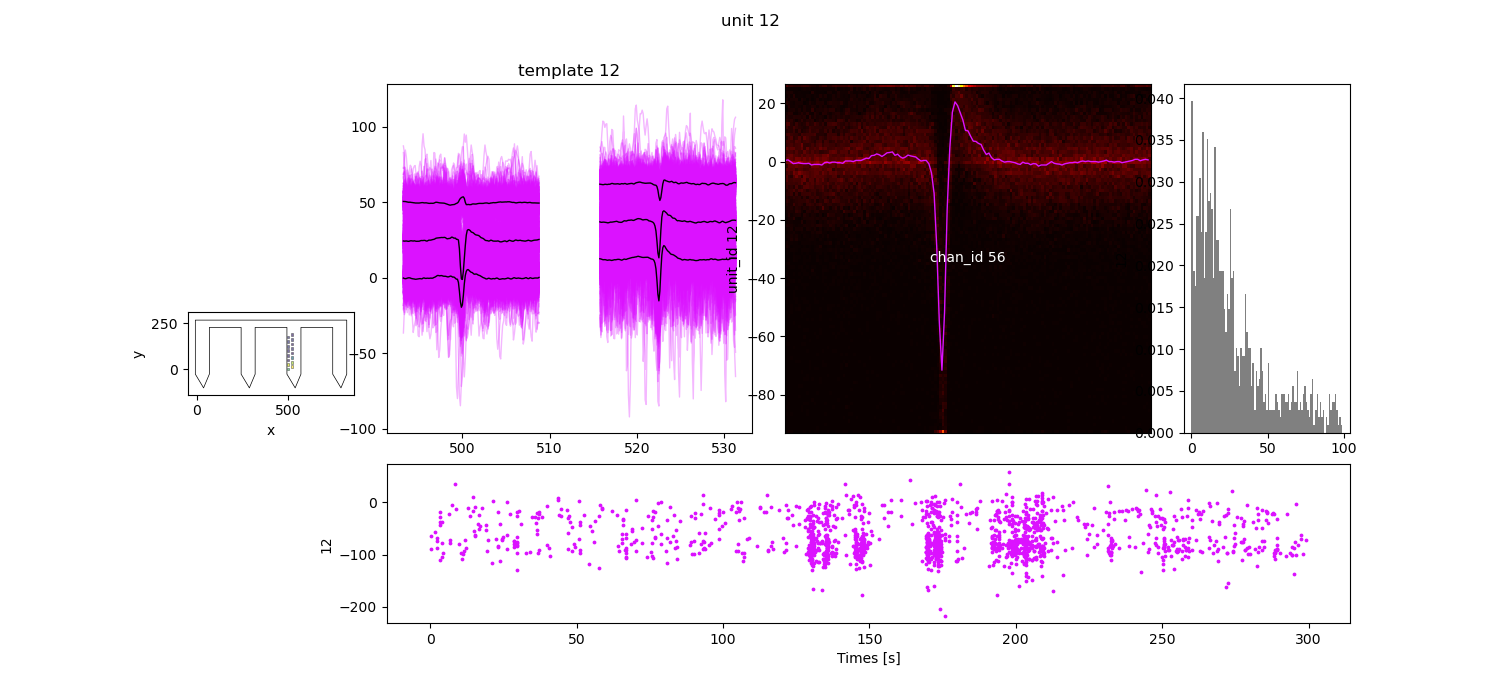

<IPython.core.display.Javascript object>


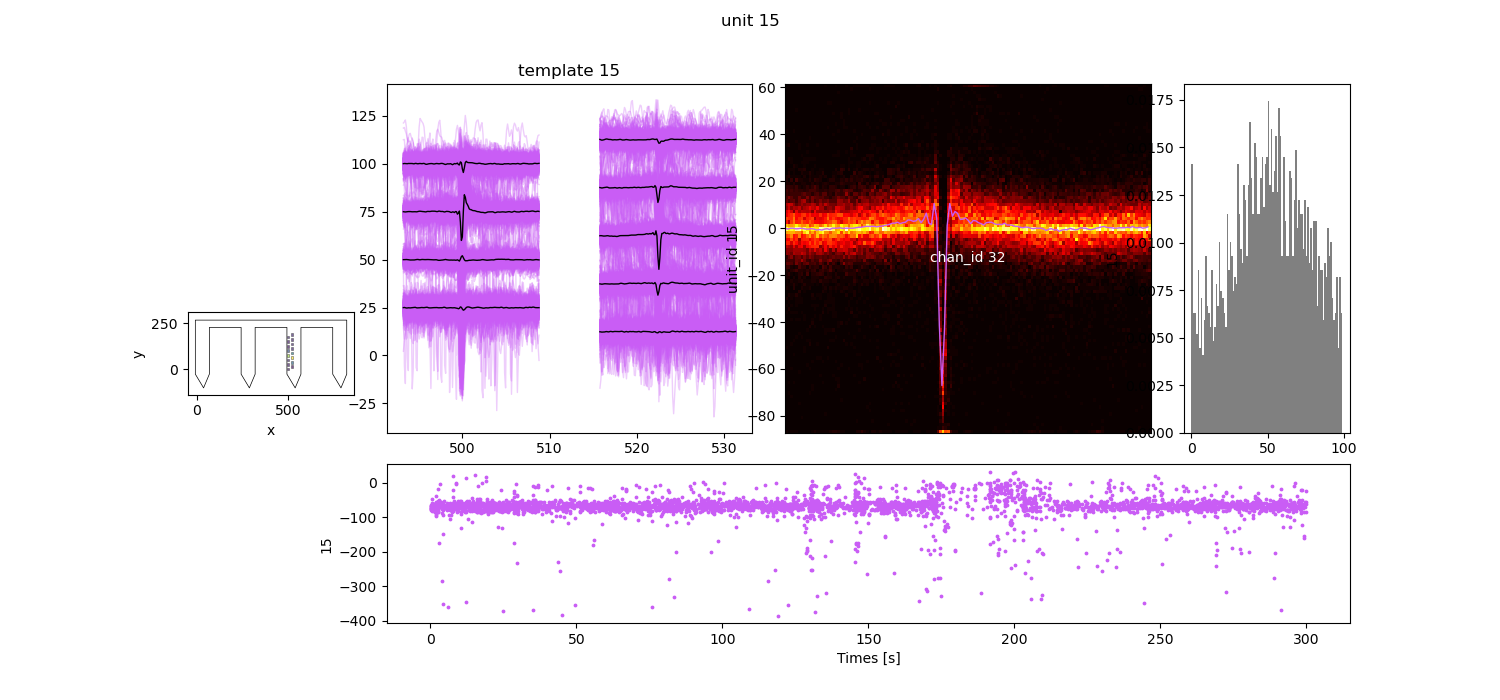

In [184]:
export_report(waveform_extractor=we_curated, output_folder="SI_report", format="pdf", 
              metrics=qc)